# Batch Document Extraction with Llama Vision (V2)

Streamlined batch processing notebook using modular components.

**V2 Features:**
- **Sophisticated bank statement extraction** using multi-turn UnifiedBankExtractor
- Turn 0: Header detection (identifies actual column names)
- Turn 1: Adaptive extraction with structure-dynamic prompts
- Automatic strategy selection: BALANCE_DESCRIPTION, AMOUNT_DESCRIPTION, etc.
- Early model loading
- Configurable output directory
- Comprehensive analytics and visualizations
- Clean, modular code structure

**Bank Statement Processing Toggle:**
- `USE_SOPHISTICATED_BANK_EXTRACTION`: True (default) uses multi-turn extraction
- `ENABLE_BALANCE_CORRECTION`: Optional mathematical balance validation

## 1. Imports

In [1]:
#Cell 1
# Project root detection - allows running from subdirectories
import sys
import os
from pathlib import Path

os.environ['EVALUATION_METHOD'] = 'order_aware_f1'  # or 'f1', 'kieval', 'order_aware_f1', 'correlation'

def find_project_root(marker_files=('common/__init__.py', 'CLAUDE.md', 'prompts')):
    """Find project root by looking for marker files, searching up from cwd."""
    current = Path().absolute()
    for parent in [current] + list(current.parents):
        for marker in marker_files:
            if (parent / marker).exists():
                return parent
    return current  # Fallback to cwd if no marker found

# Detect project root (works from any subdirectory)
PROJECT_ROOT = find_project_root()
print(f"📂 Current directory: {Path().absolute()}")
print(f"🏠 Project root: {PROJECT_ROOT}")

# Ensure the project root is in the Python path
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))
    print(f"✅ Added {PROJECT_ROOT} to sys.path")

# Enable autoreload for module changes
%load_ext autoreload
%autoreload 2

# Standard library imports
import warnings
from datetime import datetime

# Third-party imports
import numpy as np
import pandas as pd
from IPython.display import display, Image
from rich import print as rprint
from rich.console import Console

# Project-specific imports
from common.batch_analytics import BatchAnalytics
from common.batch_processor import BatchDocumentProcessor
from common.batch_reporting import BatchReporter
from common.batch_visualizations import BatchVisualizer
from common.evaluation_metrics import load_ground_truth
from common.extraction_parser import discover_images
from common.gpu_optimization import emergency_cleanup
from common.llama_model_loader_robust import load_llama_model_robust

# V2: Sophisticated bank statement processing
from common.bank_statement_adapter import BankStatementAdapter

print("✅ All imports loaded successfully")
print("✅ Llama batch processing modules imported successfully")
print("✅ V2: BankStatementAdapter imported for sophisticated bank extraction")
warnings.filterwarnings('ignore')

📂 Current directory: /home/jovyan/nfs_share/tod/LMM_POC/notebooks_v2
🏠 Project root: /home/jovyan/nfs_share/tod/LMM_POC
✅ Added /home/jovyan/nfs_share/tod/LMM_POC to sys.path
DEBUG: field_types_from_yaml = {'monetary': ['GST_AMOUNT', 'TOTAL_AMOUNT', 'LINE_ITEM_PRICES', 'LINE_ITEM_TOTAL_PRICES', 'TRANSACTION_AMOUNTS_PAID', 'TRANSACTION_AMOUNTS_RECEIVED', 'ACCOUNT_BALANCE'], 'boolean': ['IS_GST_INCLUDED'], 'list': ['LINE_ITEM_DESCRIPTIONS', 'LINE_ITEM_QUANTITIES', 'LINE_ITEM_PRICES', 'LINE_ITEM_TOTAL_PRICES', 'TRANSACTION_DATES', 'TRANSACTION_AMOUNTS_PAID', 'TRANSACTION_AMOUNTS_RECEIVED', 'ACCOUNT_BALANCE'], 'date': ['INVOICE_DATE', 'STATEMENT_DATE_RANGE', 'TRANSACTION_DATES'], 'transaction_list': ['TRANSACTION_DATES', 'TRANSACTION_AMOUNTS_PAID', 'TRANSACTION_AMOUNTS_RECEIVED', 'ACCOUNT_BALANCE']}
DEBUG: boolean fields from YAML = ['IS_GST_INCLUDED']
DEBUG: self.boolean_fields = ['IS_GST_INCLUDED']
DEBUG _ensure_fields_loaded: BOOLEAN_FIELDS = ['IS_GST_INCLUDED']
✅ All imports loaded suc

## 2. Pre-emptive Memory Cleanup

**CRITICAL for V100**: Run this cell first to prevent OOM errors when switching between models.

In [2]:
#Cell 2
# Initialize console for rich output
console = Console()# Pre-emptive V100 Memory Cleanup - Run FIRST to prevent OOM errors
rprint("[bold red]🧹 PRE-EMPTIVE V100 MEMORY CLEANUP[/bold red]")
rprint("[yellow]Clearing any existing model caches before loading...[/yellow]")
rprint("[cyan]💡 This prevents OOM errors when switching between models on V100[/cyan]")

# Emergency cleanup to ensure clean slate
emergency_cleanup(verbose=True)

rprint("[green]✅ Memory cleanup complete - ready for model loading[/green]")
rprint("[dim]📋 Next: Import modules and configure settings[/dim]")

🧹 PRE-EMPTIVE V100 MEMORY CLEANUP

Clearing any existing model caches before loading...

💡 This prevents OOM errors when switching between models on V100

🚨 Running V100 emergency GPU cleanup...
🧹 Starting V100-optimized GPU memory cleanup...
   📊 Initial GPU memory: 0.00GB allocated, 0.00GB reserved
   ✅ Final GPU memory: 0.00GB allocated, 0.00GB reserved
   💾 Memory freed: 0.00GB
✅ V100-optimized memory cleanup complete
✅ V100 emergency cleanup complete


✅ Memory cleanup complete - ready for model loading

📋 Next: Import modules and configure settings

## 3. Configuration

In [3]:
#Cell 3
# Environment-specific base paths
ENVIRONMENT_BASES = {
    'sandbox': '/home/jovyan/nfs_share/tod',
    'efs': '/efs/shared/PoC_data'
}
base_data_path = ENVIRONMENT_BASES['sandbox']

CONFIG = {
    # Model settings
    # 'MODEL_PATH': "/efs/shared/PTM/Llama-3.2-11B-Vision-Instruct",
    'MODEL_PATH': "/home/jovyan/nfs_share/models/Llama-3.2-11B-Vision-Instruct",

    # Batch settings - Using base path for consistency
    'DATA_DIR': f'{base_data_path}/LMM_POC/evaluation_data/synthetic',
    'GROUND_TRUTH': f'{base_data_path}/LMM_POC/evaluation_data/synthetic/ground_truth_synthetic.csv',
    'OUTPUT_BASE': f'{base_data_path}/LMM_POC/output',
    'MAX_IMAGES': None,  # None for all, or set limit
    'DOCUMENT_TYPES': None,  # None for all, or ['invoice', 'receipt']
    'ENABLE_MATH_ENHANCEMENT': True,  # Enable mathematical correction for bank statements
    
    # Inference and evaluation mode
    'INFERENCE_ONLY': False,  # Default: True (inference-only mode)

    # Verbosity control
    'VERBOSE': True,
    'SHOW_PROMPTS': True,

    # L40S optimization settings
    'USE_QUANTIZATION': False,
    'DEVICE_MAP': 'auto',
    'MAX_NEW_TOKENS': 3000,  # Reduced for L40S (was 4000 for V100)
    'TORCH_DTYPE': 'bfloat16',
    'LOW_CPU_MEM_USAGE': True,
    
    # ============================================================================
    # V2: SOPHISTICATED BANK STATEMENT EXTRACTION
    # ============================================================================
    'USE_SOPHISTICATED_BANK_EXTRACTION': True,
    'ENABLE_BALANCE_CORRECTION': True,
    
    # ============================================================================
    # IMAGE PREPROCESSING SETTINGS
    # ============================================================================
    'ENABLE_PREPROCESSING': True,
    'PREPROCESSING_MODE': 'adaptive',
    'SAVE_PREPROCESSED': False,
    'PREPROCESSED_DIR': None,
}

# Make GROUND_TRUTH conditional based on INFERENCE_ONLY mode
if CONFIG['INFERENCE_ONLY']:
    CONFIG['GROUND_TRUTH'] = None

# ============================================================================
# PROMPT CONFIGURATION - Uses PROJECT_ROOT for subdirectory compatibility
# ============================================================================
PROMPT_CONFIG = {
    # Document type detection configuration
    'detection_file': str(PROJECT_ROOT / 'prompts/document_type_detection.yaml'),
    'detection_key': 'detection',
    
    # Extraction prompt file mapping (REQUIRED)
    'extraction_files': {
        'INVOICE': str(PROJECT_ROOT / 'prompts/generated/llama_invoice_prompt.yaml'),
        'RECEIPT': str(PROJECT_ROOT / 'prompts/generated/llama_receipt_prompt.yaml'),
        # BANK_STATEMENT: Only used if USE_SOPHISTICATED_BANK_EXTRACTION=False or as fallback
        'BANK_STATEMENT': str(PROJECT_ROOT / 'prompts/generated/llama_bank_statement_prompt.yaml')
    },
}

print("✅ Configuration set up successfully")
print(f"📂 Data directory: {CONFIG['DATA_DIR']}")
print(f"📊 Ground truth: {CONFIG['GROUND_TRUTH']}")
print(f"🤖 Model path: {CONFIG['MODEL_PATH']}")
print(f"📁 Output base: {CONFIG['OUTPUT_BASE']}")
print(f"🏠 Project root: {PROJECT_ROOT}")
print(f"🎯 Mode: {'Inference-only' if CONFIG['INFERENCE_ONLY'] else 'Evaluation mode'}")
print(f"🔧 Preprocessing: {'Enabled (' + CONFIG['PREPROCESSING_MODE'] + ')' if CONFIG['ENABLE_PREPROCESSING'] else 'Disabled'}")
print(f"🏦 V2 Bank Extraction: {'Enabled (multi-turn)' if CONFIG['USE_SOPHISTICATED_BANK_EXTRACTION'] else 'Disabled (single-turn)'}")
print(f"📐 Balance Correction: {'Enabled' if CONFIG['ENABLE_BALANCE_CORRECTION'] else 'Disabled'}")

✅ Configuration set up successfully
📂 Data directory: /home/jovyan/nfs_share/tod/LMM_POC/evaluation_data/synthetic
📊 Ground truth: /home/jovyan/nfs_share/tod/LMM_POC/evaluation_data/synthetic/ground_truth_synthetic.csv
🤖 Model path: /home/jovyan/nfs_share/models/Llama-3.2-11B-Vision-Instruct
📁 Output base: /home/jovyan/nfs_share/tod/LMM_POC/output
🏠 Project root: /home/jovyan/nfs_share/tod/LMM_POC
🎯 Mode: Evaluation mode
🔧 Preprocessing: Enabled (adaptive)
🏦 V2 Bank Extraction: Enabled (multi-turn)
📐 Balance Correction: Enabled


## 3.5 Output Redirection Utility (Optional)

Use the `redirect_output_to_file()` context manager to save verbose output to a file instead of displaying in the notebook.

In [4]:
# #Cell 3.5
# import sys
# from contextlib import contextmanager
# from pathlib import Path

# @contextmanager
# def redirect_output_to_file(filepath):
#     """
#     Context manager to redirect stdout to a file.
    
#     Usage:
#         log_path = OUTPUT_DIRS['base'] / f'batch_log_{BATCH_TIMESTAMP}.txt'
#         with redirect_output_to_file(log_path):
#             # Your verbose code here
#             batch_results, processing_times, document_types_found = processor.process_batch(
#                 all_images, verbose=True
#             )
#         # Output is back to notebook
    
#     Args:
#         filepath: Path where output should be saved
        
#     Yields:
#         File handle for the log file
#     """
#     log_file = Path(filepath)
#     log_file.parent.mkdir(parents=True, exist_ok=True)
    
#     original_stdout = sys.stdout
#     original_stderr = sys.stderr
    
#     with open(log_file, 'w') as f:
#         sys.stdout = f
#         sys.stderr = f
#         try:
#             yield f
#         finally:
#             sys.stdout = original_stdout
#             sys.stderr = original_stderr
    
#     print(f"✅ Output saved to: {log_file}")

# print("✅ Output redirection utility loaded")
# print("📝 Use: with redirect_output_to_file('path/to/log.txt'): ...")

## 4. Output Directory Setup

In [5]:
#Cell 4
# Setup output directories - Handle both absolute and relative paths

# Convert OUTPUT_BASE to Path and handle absolute/relative paths
OUTPUT_BASE = Path(CONFIG['OUTPUT_BASE'])
if not OUTPUT_BASE.is_absolute():
    # If relative, make it relative to current working directory
    OUTPUT_BASE = Path.cwd() / OUTPUT_BASE

BATCH_TIMESTAMP = datetime.now().strftime("%Y%m%d_%H%M%S")

OUTPUT_DIRS = {
    'base': OUTPUT_BASE,
    'batch': OUTPUT_BASE / 'batch_results',
    'csv': OUTPUT_BASE / 'csv',
    'visualizations': OUTPUT_BASE / 'visualizations',
    'reports': OUTPUT_BASE / 'reports'
}

for dir_path in OUTPUT_DIRS.values():
    dir_path.mkdir(parents=True, exist_ok=True)

## 5. Model Loading

In [6]:
#Cell 5
# Load model once for entire batch
rprint("[bold green]Loading model with robust multi-GPU detection...[/bold green]")

model, processor = load_llama_model_robust(
    model_path=CONFIG['MODEL_PATH'],
    use_quantization=CONFIG['USE_QUANTIZATION'],
    device_map=CONFIG['DEVICE_MAP'],
    max_new_tokens=CONFIG['MAX_NEW_TOKENS'],
    torch_dtype=CONFIG['TORCH_DTYPE'],
    low_cpu_mem_usage=CONFIG['LOW_CPU_MEM_USAGE'],
    verbose=CONFIG['VERBOSE']
)

# Model and processor will be used directly by DocumentAwareLlamaProcessor in batch processing
rprint("[bold green]✅ Model ready for document-aware processing with robust detection[/bold green]")

Loading model with robust multi-GPU detection...

🚀 Loading Llama Vision model with robust multi-GPU optimization...

Features: Smart quantization, memory management, V100 support

🔧 Configuring CUDA memory for Llama...

🔧 CUDA memory allocation configured: max_split_size_mb:64
💡 Using 64MB memory blocks to reduce fragmentation
📊 Initial CUDA state: Allocated=0.00GB, Reserved=0.00GB


🔍 Performing robust GPU memory detection...

🔍 Starting robust GPU memory detection...
📊 Detected 1 GPU(s), analyzing each device...
   GPU 0 (NVIDIA L4): 22.0GB total, 22.0GB available

🔍 ROBUST GPU MEMORY DETECTION REPORT
✅ Success: 1/1 GPUs detected
📊 Total Memory: 21.95GB
💾 Available Memory: 21.95GB
⚡ Allocated Memory: 0.00GB
🔄 Reserved Memory: 0.00GB
📦 Fragmentation: 0.00GB
🖥️  Multi-GPU: No
⚖️  Balanced Distribution: Yes

📋 Per-GPU Breakdown:
   GPU 0 (NVIDIA L4): 22.0GB total, 22.0GB available (0.0% used)


📊 GPU Hardware: NVIDIA L4 (1x 22GB = 22GB total)

🏗️ Architecture: cloud_inference (dynamic detection)

🎯 Model: Llama-3.2-11B-Vision (full precision: 22.0GB, threshold: 24.0GB)

💾 Available Memory: 22.0GB across 1 GPU(s)

💡 Memory sufficient: ❌ No

✅ Cloud inference GPU with 22GB - running in full precision as requested

📊 FINAL QUANTIZATION DECISION: DISABLED (full precision)

   Total GPU Memory: 22GB

   Available Memory: 22GB

Full precision needs: 22.0GB + 2.0GB buffer = 24.0GB threshold

   Working GPUs: 1/1

🚀 Using 16-bit precision for optimal performance

Loading Llama Vision model...

The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.


Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

Some parameters are on the meta device because they were offloaded to the cpu.


Loading processor...

✅ Model and processor loaded successfully!

📊 Single GPU Analysis:

   Device: cuda:0

   GPU: NVIDIA L4

   Memory: 19.79GB allocated, 20.09GB reserved, 24GB total

                            🔧 Llama Vision Model Configuration                            
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Setting             ┃ Value                         ┃ Llama Status                      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Model Path          │ Llama-3.2-11B-Vision-Instruct │ ✅ Valid                          │
│ Device Placement    │ cuda:0                        │ ✅ Loaded                         │
│ Quantization Method │ 16-bit                        │ ✅ 16-bit (Performance Optimized) │
│ Data Type           │ bfloat16                      │ ✅ Recommended                    │
│ Max New Tokens      │ 3000                          │ ✅ Generation Ready               │
│ GPU Configuration   │ 1 GPU(s)                      │ ✅ Available                      │
│ Model Parameters    │ 10,670,220,835                │ ✅ Loaded                         │
│ Memory Optimization │ Llama Robust                  │ ✅ V100 Compatible                │
└─────────────────────┴───────────────────────────────┴───────────────────────────────────┘

Running model compatibility test...

✅ Model compatibility test passed

Performing initial memory cleanup...

🧹 Memory cleanup completed

💾 Final state: Allocated=19.79GB, Reserved=20.09GB, Fragmentation=0.30GB

🎉 Llama Vision model loading and validation complete!

🔧 Llama optimizations active: 16-bit precision, memory management, vision preservation

✅ Model ready for document-aware processing with robust detection

## 6. Image Discovery

In [7]:
#Cell 6
# Discover and filter images - Handle both absolute and relative paths

# Convert DATA_DIR to Path and handle absolute/relative paths
data_dir = Path(CONFIG['DATA_DIR'])
if not data_dir.is_absolute():
    # If relative, make it relative to current working directory
    data_dir = Path.cwd() / data_dir

# Discover images from the resolved data directory
all_images = discover_images(str(data_dir))

# ============================================================================
# IMAGE PREPROCESSING (Optional)
# ============================================================================
# Apply preprocessing if enabled in CONFIG
if CONFIG['ENABLE_PREPROCESSING']:
    import tempfile
    from common.image_preprocessing import (
        enhance_statement_quality,
        enhance_for_llama,
        preprocess_statement_for_llama,
        adaptive_enhance,
        preprocess_recommended
    )
    
    # Map preprocessing mode to function
    preprocess_functions = {
        'light': enhance_statement_quality,
        'moderate': enhance_for_llama,
        'aggressive': preprocess_statement_for_llama,
        'adaptive': adaptive_enhance,
        'recommended': preprocess_recommended
    }
    
    preprocess_fn = preprocess_functions[CONFIG['PREPROCESSING_MODE']]
    preprocessed_images = []
    
    rprint(f"[cyan]🔧 Preprocessing {len(all_images)} images (mode: {CONFIG['PREPROCESSING_MODE']})[/cyan]")
    
    # Setup output directory for preprocessed images
    if CONFIG['SAVE_PREPROCESSED']:
        # Save to persistent directory
        preprocessed_dir = Path(CONFIG['PREPROCESSED_DIR'] or 'preprocessed_images')
        preprocessed_dir.mkdir(parents=True, exist_ok=True)
        rprint(f"[cyan]📁 Saving preprocessed images to: {preprocessed_dir}[/cyan]")
    else:
        # Save to temporary directory (preserves original filenames)
        preprocessed_dir = Path(tempfile.mkdtemp(prefix='preprocessed_'))
        rprint(f"[cyan]📁 Using temporary directory: {preprocessed_dir}[/cyan]")
    
    # Preprocess each image
    for img_path in all_images:
        original_filename = Path(img_path).name
        
        try:
            # Apply preprocessing function
            preprocessed_img = preprocess_fn(img_path)
            
            # Save with original filename (either to persistent or temp directory)
            preprocessed_path = preprocessed_dir / original_filename
            preprocessed_img.save(preprocessed_path)
            preprocessed_images.append(str(preprocessed_path))
            
        except Exception as e:
            rprint(f"[yellow]⚠️  Preprocessing failed for {original_filename}: {e}[/yellow]")
            rprint(f"[yellow]   Using original image instead[/yellow]")
            preprocessed_images.append(img_path)  # Fallback to original
    
    # Replace original image paths with preprocessed paths
    all_images = preprocessed_images
    rprint(f"[green]✅ Preprocessing complete ({len(preprocessed_images)} images)[/green]")
else:
    rprint("[dim]⏭️  Preprocessing disabled - using original images[/dim]")

# ============================================================================
# GROUND TRUTH LOADING
# ============================================================================
# Conditionally load ground truth only when not in inference-only mode
ground_truth = {}
if not CONFIG['INFERENCE_ONLY'] and CONFIG['GROUND_TRUTH']:
    # Convert GROUND_TRUTH to Path and handle absolute/relative paths
    ground_truth_path = Path(CONFIG['GROUND_TRUTH'])
    if not ground_truth_path.is_absolute():
        # If relative, make it relative to current working directory
        ground_truth_path = Path.cwd() / ground_truth_path
    
    # Load ground truth from the resolved path
    ground_truth = load_ground_truth(str(ground_truth_path), verbose=CONFIG['VERBOSE'])
    
    rprint(f"[green]✅ Ground truth loaded for {len(ground_truth)} images[/green]")
else:
    rprint("[cyan]📋 Running in inference-only mode (no ground truth required)[/cyan]")

# Apply filters (only if ground truth is available)
if CONFIG['DOCUMENT_TYPES'] and ground_truth:
    filtered = []
    for img in all_images:
        img_name = Path(img).name
        if img_name in ground_truth:
            doc_type = ground_truth[img_name].get('DOCUMENT_TYPE', '').lower()
            if any(dt.lower() in doc_type for dt in CONFIG['DOCUMENT_TYPES']):
                filtered.append(img)
    all_images = filtered

if CONFIG['MAX_IMAGES']:
    all_images = all_images[:CONFIG['MAX_IMAGES']]

rprint(f"[bold green]Ready to process {len(all_images)} images[/bold green]")
rprint(f"[cyan]Data directory: {data_dir}[/cyan]")
if not CONFIG['INFERENCE_ONLY'] and CONFIG['GROUND_TRUTH']:
    rprint(f"[cyan]Ground truth: {ground_truth_path}[/cyan]")
rprint(f"[cyan]Mode: {'Inference-only' if CONFIG['INFERENCE_ONLY'] else 'Evaluation mode'}[/cyan]")
for i, img in enumerate(all_images[:5], 1):
    print(f"  {i}. {Path(img).name}")
if len(all_images) > 5:
    print(f"  ... and {len(all_images) - 5} more")

🔧 Preprocessing 9 images (mode: adaptive)

📁 Using temporary directory: /tmp/preprocessed_4uavjo4y

✅ Preprocessing complete (9 images)

📊 Ground truth CSV loaded with 9 rows and 20 columns
📋 Available columns: ['image_file', 'DOCUMENT_TYPE', 'BUSINESS_ABN', 'BUSINESS_ADDRESS', 'GST_AMOUNT', 'INVOICE_DATE', 'IS_GST_INCLUDED', 'LINE_ITEM_DESCRIPTIONS', 'LINE_ITEM_QUANTITIES', 'LINE_ITEM_PRICES', 'LINE_ITEM_TOTAL_PRICES', 'PAYER_ADDRESS', 'PAYER_NAME', 'STATEMENT_DATE_RANGE', 'SUPPLIER_NAME', 'TOTAL_AMOUNT', 'TRANSACTION_AMOUNTS_PAID', 'TRANSACTION_DATES', 'TRANSACTION_AMOUNTS_RECEIVED', 'ACCOUNT_BALANCE']
✅ Using 'image_file' as image identifier column
✅ Ground truth mapping created for 9 images


✅ Ground truth loaded for 9 images

Ready to process 9 images

Data directory: /home/jovyan/nfs_share/tod/LMM_POC/evaluation_data/synthetic

Ground truth: /home/jovyan/nfs_share/tod/LMM_POC/evaluation_data/synthetic/ground_truth_synthetic.csv

Mode: Evaluation mode

  1. cba_amount_balance.png
  2. cba_debit_credit.png
  3. cba_highligted.png
  4. image_001.png
  5. image_002.png
  ... and 4 more


In [8]:
#Cell 7
# ============================================================================
# V2: BATCH PROCESSING WITH SOPHISTICATED BANK STATEMENT EXTRACTION
# ============================================================================
# This cell initializes the batch processor and sets up document routing:
#
# Document Flow:
# 1. Document type detection (Turn 0) - classify as INVOICE, RECEIPT, or BANK_STATEMENT
# 2. If BANK_STATEMENT:
#    - Turn 1: Header detection via BankStatementAdapter
#    - Turn 2: Adaptive extraction based on detected columns
# 3. If INVOICE/RECEIPT:
#    - Standard single-turn extraction
#
# This ensures NO duplicate extraction - each document is processed once.
# ============================================================================

# Initialize batch processor with simplified, clean architecture
batch_processor = BatchDocumentProcessor(
    model=model,
    processor=processor,
    prompt_config=PROMPT_CONFIG,
    ground_truth_csv=CONFIG['GROUND_TRUTH'],  # None in inference-only mode
    console=console,
    enable_math_enhancement=CONFIG['ENABLE_MATH_ENHANCEMENT']
)

# V2: Set up sophisticated bank statement extraction if enabled
if CONFIG.get('USE_SOPHISTICATED_BANK_EXTRACTION', False):
    rprint("[bold cyan]🏦 V2: Setting up sophisticated bank statement extraction...[/bold cyan]")
    
    # Create bank adapter for multi-turn extraction
    bank_adapter = BankStatementAdapter(
        model=model,
        processor=processor,
        verbose=CONFIG['VERBOSE'],
        use_balance_correction=CONFIG.get('ENABLE_BALANCE_CORRECTION', False),
    )
    
    # Store original processing method for non-bank documents
    original_process_llama = batch_processor._process_llama_image
    
    # Load detection config once for reuse
    from pathlib import Path as _Path
    import yaml as _yaml
    _detection_path = _Path(PROMPT_CONFIG["detection_file"])
    with _detection_path.open("r") as _f:
        _detection_config = _yaml.safe_load(_f)
    _detection_prompt_key = PROMPT_CONFIG.get("detection_key") or _detection_config.get("settings", {}).get("default_prompt", "detection")
    _doc_type_prompt = _detection_config["prompts"][_detection_prompt_key]["prompt"]
    _max_tokens = _detection_config.get("settings", {}).get("max_new_tokens", 50)
    
    def detect_document_type_only(image_path):
        """
        Detection-only function for Llama - returns just the document type.
        Does NOT perform extraction.
        """
        import torch
        from PIL import Image
        
        # Load image
        image = Image.open(image_path)
        
        # Create message structure
        messageDataStructure = [
            {
                "role": "user",
                "content": [
                    {"type": "image"},
                    {"type": "text", "text": _doc_type_prompt},
                ],
            }
        ]
        
        # Process input
        textInput = processor.apply_chat_template(messageDataStructure, add_generation_prompt=True)
        inputs = processor(image, textInput, return_tensors="pt")
        
        # Move to model device
        inputs = inputs.to(model.device)
        
        # Generate response
        with torch.no_grad():
            output = model.generate(
                **inputs,
                max_new_tokens=_max_tokens,
                do_sample=False,
                temperature=None,
                top_p=None,
            )
        response = processor.decode(output[0], skip_special_tokens=True)
        
        # Parse document type from response
        response_text = response.split("assistant")[-1].strip() if "assistant" in response else response
        response_upper = response_text.upper()
        
        # Debug: Show what the model returned
        print(f"  [DEBUG] Detection response: {response_text[:100]}...")
        
        # More specific matching - avoid false positives from "STATEMENT" in other contexts
        if "BANK STATEMENT" in response_upper or "BANK_STATEMENT" in response_upper:
            return "BANK_STATEMENT"
        elif "RECEIPT" in response_upper:
            return "RECEIPT"
        else:
            return "INVOICE"
    
    def enhanced_process_llama(image_path, verbose):
        """
        Enhanced processing with proper routing:
        - Turn 0: Document type detection (all documents)
        - If BANK_STATEMENT: BankStatementAdapter handles extraction (Turn 1 headers + Turn 2 extraction)
        - If INVOICE/RECEIPT: Standard extraction via original_process_llama
        
        NO duplicate extraction - each document processed exactly once.
        """
        from pathlib import Path
        
        # =====================================================================
        # TURN 0: Document Type Detection ONLY (no extraction yet)
        # =====================================================================
        if verbose:
            rprint(f"\n[cyan]📋 Turn 0: Document type detection for {Path(image_path).name}[/cyan]")
        
        try:
            doc_type = detect_document_type_only(image_path)
        except Exception as e:
            rprint(f"[red]Error in document type detection: {e}[/red]")
            raise
        
        if verbose:
            rprint(f"[green]✅ Detected: {doc_type}[/green]")
        
        # =====================================================================
        # ROUTING: Bank statements vs other documents
        # =====================================================================
        if doc_type.upper() == "BANK_STATEMENT":
            # -----------------------------------------------------------------
            # BANK STATEMENT: Use BankStatementAdapter (Turn 1 + Turn 2)
            # -----------------------------------------------------------------
            if verbose:
                rprint(f"[cyan]🏦 Routing to BankStatementAdapter for multi-turn extraction[/cyan]")
            
            try:
                # BankStatementAdapter handles:
                # - Turn 1: Header detection (identifies column names)
                # - Turn 2: Adaptive extraction based on detected columns
                schema_fields, metadata = bank_adapter.extract_bank_statement(image_path)
                
                # Build result structure compatible with BatchDocumentProcessor
                extraction_result = {
                    "extracted_data": schema_fields,
                    "raw_response": metadata.get("raw_responses", {}).get("turn1", ""),
                    "field_list": list(schema_fields.keys()),
                    "metadata": metadata,
                    # Skip batch_processor's math enhancement - already done by UnifiedBankExtractor
                    "skip_math_enhancement": True,
                }
                
                # Create prompt name indicating strategy used
                strategy = metadata.get("strategy_used", "unknown")
                prompt_name = f"unified_bank_{strategy}"
                
                if verbose:
                    rprint(f"[green]  ✅ Strategy: {strategy}[/green]")
                    tx_count = len(schema_fields.get('TRANSACTION_DATES', '').split('|')) if schema_fields.get('TRANSACTION_DATES') != 'NOT_FOUND' else 0
                    rprint(f"[green]  ✅ Transactions extracted: {tx_count}[/green]")
                
                return doc_type, extraction_result, prompt_name
                
            except Exception as e:
                rprint(f"[yellow]⚠️  BankStatementAdapter failed: {e}[/yellow]")
                rprint(f"[yellow]   Falling back to standard extraction...[/yellow]")
                # Fall through to standard extraction
        
        # -----------------------------------------------------------------
        # INVOICE/RECEIPT (or bank fallback): Standard extraction
        # -----------------------------------------------------------------
        if verbose:
            rprint(f"[dim]📄 Using standard extraction for {doc_type}[/dim]")
        
        # Use original process (will re-detect but that's acceptable for non-bank)
        return original_process_llama(image_path, verbose)
    
    # Replace the processing method
    batch_processor._process_llama_image = enhanced_process_llama
    
    rprint("[green]✅ V2: Sophisticated bank statement extraction enabled[/green]")
    rprint("[cyan]   Flow: Detection → Route → Extract (no duplicate processing for bank)[/cyan]")
    rprint("[cyan]   Bank statements: Turn 0 (detect) → Turn 1 (headers) → Turn 2 (extract)[/cyan]")
    rprint("[cyan]   Invoice/Receipt: Turn 0 (detect) → Standard extraction[/cyan]")
    rprint(f"[cyan]   Balance correction: {'Enabled' if CONFIG.get('ENABLE_BALANCE_CORRECTION', False) else 'Disabled'}[/cyan]")
else:
    rprint("[dim]⏭️  V2: Sophisticated bank extraction disabled - using original single-turn[/dim]")

# Process batch with CONFIG verbose setting for detailed field comparison
batch_results, processing_times, document_types_found = batch_processor.process_batch(
    all_images, verbose=CONFIG['VERBOSE']
)

# Brief summary
rprint(f"[bold green]✅ Processed {len(batch_results)} images[/bold green]")
rprint(f"[cyan]Average time: {np.mean(processing_times):.2f}s[/cyan]")
if CONFIG['INFERENCE_ONLY']:
    rprint("[cyan]📋 Inference-only mode: No accuracy evaluation performed[/cyan]")
else:
    avg_accuracy = np.mean([r.get('evaluation', {}).get('overall_accuracy', 0) * 100 for r in batch_results if 'evaluation' in r])
    rprint(f"[cyan]Average accuracy: {avg_accuracy:.1f}%[/cyan]")
    
    # V2: Show bank statement specific results if sophisticated extraction was used
    if CONFIG.get('USE_SOPHISTICATED_BANK_EXTRACTION', False):
        bank_results = [r for r in batch_results if r.get('document_type', '').upper() == 'BANK_STATEMENT']
        if bank_results:
            bank_accuracy = np.mean([r.get('evaluation', {}).get('overall_accuracy', 0) * 100 for r in bank_results if 'evaluation' in r])
            rprint(f"[cyan]🏦 Bank statement accuracy (V2): {bank_accuracy:.1f}%[/cyan]")


🏦 V2: Setting up sophisticated bank statement extraction...

[BSA] Created BankStatementAdapter instance #1 (model_type=llama)


✅ V2: Sophisticated bank statement extraction enabled

   Flow: Detection → Route → Extract (no duplicate processing for bank)

   Bank statements: Turn 0 (detect) → Turn 1 (headers) → Turn 2 (extract)

   Invoice/Receipt: Turn 0 (detect) → Standard extraction

   Balance correction: Enabled

📊 Ground truth CSV loaded with 9 rows and 20 columns
📋 Available columns: ['image_file', 'DOCUMENT_TYPE', 'BUSINESS_ABN', 'BUSINESS_ADDRESS', 'GST_AMOUNT', 'INVOICE_DATE', 'IS_GST_INCLUDED', 'LINE_ITEM_DESCRIPTIONS', 'LINE_ITEM_QUANTITIES', 'LINE_ITEM_PRICES', 'LINE_ITEM_TOTAL_PRICES', 'PAYER_ADDRESS', 'PAYER_NAME', 'STATEMENT_DATE_RANGE', 'SUPPLIER_NAME', 'TOTAL_AMOUNT', 'TRANSACTION_AMOUNTS_PAID', 'TRANSACTION_DATES', 'TRANSACTION_AMOUNTS_RECEIVED', 'ACCOUNT_BALANCE']
✅ Using 'image_file' as image identifier column
✅ Ground truth mapping created for 9 images


✅ Loaded ground truth for 9 images

📋 Sample GT keys: ['image_001.png', 'image_002.png', 'image_004.png']

🚀 Starting Batch Processing

──────────────────────────────────────────────── Batch Extraction ─────────────────────────────────────────────────

Output()

Processing [1/9]: cba_amount_balance.png

📋 Turn 0: Document type detection for cba_amount_balance.png

[DEBUG] Detection response: This document is a bank statement, specifically a credit card statement, as it lists 
transactions wi...

✅ Detected: BANK_STATEMENT

🏦 Routing to BankStatementAdapter for multi-turn extraction


[BSA#1] >>> START extract_bank_statement(cba_amount_balance.png)
[UBE] Turn 0: Detecting headers...
  Detected 4 headers: ['Date', 'Transaction details', 'Amount', 'Balance']
  Balance column: Balance
  Amount column: Amount
  Debit column: NOT FOUND
  Credit column: NOT FOUND
  has_balance=True, has_amount=True, has_debit_or_credit=None
[UBE] Strategy: AMOUNT_DESCRIPTION (Balance + Amount column detected (signed values))
[UBE] Turn 1: Extracting transactions (amount-description)...


  ✅ Strategy: amount_description_2turn

  ✅ Transactions extracted: 12

⏭️  Skipping batch_processor math enhancement (handled by UnifiedBankExtractor)

✓ Extracted 6 fields from cba_amount_balance.png

🎯 Evaluating using mathematically corrected values (not raw VLM output)

✓ Overall F1 Score (Accuracy): 88.0% for cba_amount_balance.png

  Precision: 100.0% | Recall: 85.0%

🔍 DEBUG: model_type=llama, has_field_scores=True, field_count=5

===================================================================================================================
=====

📋 STEP 4: Extracted Data Results with Ground Truth Comparison

===================================================================================================================
=====

🔍 EXTRACTED DATA:

✅ DOCUMENT_TYPE: BANK_STATEMENT

✅ STATEMENT_DATE_RANGE: 03 Jun 2023 - 14 Jun 2023

✅ TRANSACTION_DATES: 03 Jun 2023 | 04 Jun 2023 | 06 Jun 2023 | 06 Jun 2023 | 07 Jun 2023 | 08 Jun 2023 | 08 Jun 
2023 | 09 Jun 2023 | 09 Jun 2023 | 10 Jun 2023 | 12 Jun 2023 | 14 Jun 2023

✅ LINE_ITEM_DESCRIPTIONS: GROCERY MARKET SUBURB NSW AUS | DEPARTMENT STORE SHOPPING DIST NS AUS | CAFE CENTRAL T 
54321F SUBURB AUS | CAFE CENTRAL T 54321F SUBURB AUS | ONLINE RETAILER.COM SYDNEY AU AUS | SERVICE STATION SUBURB 
NS AUS | SERVICE STATION SUBURB NS AUS | ONLINE SUBSCRIPTION SYDNEY AU AUS | ONLINE SUBSCRIPTION SYDNEY AU AUS | 
ELECTRONICS 9876 SUBURB NSW AUS | PHARMACY SERVICES MELBOURNE AUS | BOOKSTORE 2345 SYDNEY AUS

✅ TRANSACTION_AMOUNTS_PAID: -$78.90 | -$345.80 | -$24.50 | -$31.20 | -$18.95 | -$95.40 | -$28.60 | -$89.00 | 
-$145.50 | -$567.30 | -$42.85 | -$234.90

✅ ACCOUNT_BALANCE: $9,256.15 | $8,910.35 | $8,885.85 | $8,854.65 | $8,835.70 | $8,740.30 | $8,711.70 | $8,622.70 |
$8,477.20 | $7,909.90 | $7,867.05 | $7,632.15

📊 Ground truth loaded for cba_amount_balance.png

-------------------------------------------------------------------------------------------------------------------
-----

STATUS   FIELD                     EXTRACTED                                GROUND TRUTH

===================================================================================================================
=====

✅        DOCUMENT_TYPE             BANK_STATEMENT                           BANK_STATEMENT

✅        STATEMENT_DATE_RANGE      03 Jun 2023 - 14 Jun 2023                03 Jun 2023 - 14 Jun 2023

❌        LINE_ITEM_DESCRIPTIONS    GROCERY MARKET SUBURB NSW AUS | DEPART... GROCERY MARKET SUBURB NSW AUS Card 
xx5...

  ⚠️ MISMATCH DETAILS (F1=40.0%, P=100.0%, R=25.0%):

     Extracted (full): GROCERY MARKET SUBURB NSW AUS | DEPARTMENT STORE SHOPPING DIST NS AUS | CAFE CENTRAL T 
54321F SUBURB AUS | CAFE CENTRAL T 54321F SUBURB AUS | ONLINE RETAILER.COM SYDNEY AU AUS | SERVICE STATION SUBURB 
NS AUS | SERVICE STATION SUBURB NS AUS | ONLINE SUBSCRIPTION SYDNEY AU AUS | ONLINE SUBSCRIPTION SYDNEY AU AUS | 
ELECTRONICS 9876 SUBURB NSW AUS | PHARMACY SERVICES MELBOURNE AUS | BOOKSTORE 2345 SYDNEY AUS

     Ground Truth (full): GROCERY MARKET SUBURB NSW AUS Card xx5678 | DEPARTMENT STORE SHOPPING DIST NS AUS Card 
xx5678 | CAFE CENTRAL T 54321F SUBURB AUS Card xx5678 | CAFE CENTRAL T 54321F SUBURB AUS Card xx5678 | ONLINE 
RETAILER.COM SYDNEY AU AUS Card xx5678 | SERVICE STATION SUBURB NS AUS Card xx5678 | SERVICE STATION SUBURB NS AUS 
Card xx5678 | ONLINE SUBSCRIPTION SYDNEY AU AUS Card xx5678 | ONLINE SUBSCRIPTION SYDNEY AU AUS Card xx5678 | 
ELECTRONICS 9876 SUBURB NSW AUS Card xx5678 | PHARMACY SERVICES MELBOURNE AUS Card xx5678 | BOOKSTORE 2345 SYDNEY 
AUS Card xx5678

     Metrics: TP=3, FP=0, FN=9

     List comparison: 12 extracted vs 12 ground truth

     True Positives (correct): 3

     False Positives (extra): 0

     False Negatives (missing): 9

     ✓ Correct (position-aware):

       Pos 1: DEPARTMENT STORE SHOPPING DIST NS AUS

       Pos 2: CAFE CENTRAL T 54321F SUBURB AUS

       Pos 3: CAFE CENTRAL T 54321F SUBURB AUS

     ≈ Wrong at position: (+6 more)

       Pos 0: 'GROCERY MARKET SUBURB NSW AUS' vs 'GROCERY MARKET SUBURB NSW AUS Card xx5678'

       Pos 4: 'ONLINE RETAILER.COM SYDNEY AU AUS' vs 'ONLINE RETAILER.COM SYDNEY AU AUS Card xx5678'

       Pos 5: 'SERVICE STATION SUBURB NS AUS' vs 'SERVICE STATION SUBURB NS AUS Card xx5678'

✅        TRANSACTION_DATES         03 Jun 2023 | 04 Jun 2023 | 06 Jun 202... 03 Jun 2023 | 04 Jun 2023 | 06 Jun 
202...

✅        TRANSACTION_AMOUNTS_PAID  -$78.90 | -$345.80 | -$24.50 | -$31.20... -$78.90 | -$345.80 | -$24.50 | 
-$31.20...

📊 EXTRACTION SUMMARY:

✅ Fields Found: 5/5 (100.0%)

🎯 Exact Matches: 4/5 (80.0%)

📈 Extraction Success Rate: 88.0%

⏱️ Accuracy (matches/total): 88.0%

🤖 Document Type: BANK_STATEMENT

🔧 Model: Llama-3.2-11B-Vision-Instruct

≈ = Partial match

✗ = No match

Note: Meets accuracy threshold (80%): ✅ Yes

===================================================================================================================
=====

Processing [2/9]: cba_debit_credit.png

📋 Turn 0: Document type detection for cba_debit_credit.png

[UBE]   Parsed 12 transactions
[UBE]   Filtered to 12 withdrawal transactions
[UBE]   Array lengths: dates=12, desc=12, amounts=12, balances=12
[UBE] Raw Turn 1 response:
1. **03 Jun 2023**
   - Transaction details: GROCERY MARKET SUBURB NSW AUS
   - Amount: -$78.90
   - Balance: $9,256.15

2. **04 Jun 2023**
   - Transaction details: DEPARTMENT STORE SHOPPING DIST NS AUS
   - Amount: -$345.80
   - Balance: $8,910.35

3. **06 Jun 2023**
   - Transaction details: CAFE CENTRAL T 54321F SUBURB AUS
   - Amount: -$24.50
   - Balance: $8,885.85

4. **06 Jun 2023**
   - Transaction details: CAFE CENTRAL T 54321F SUBURB AUS
   - Amount: -$31.20
   - Balance: $8,854.65

5. **07 Jun 2023**
   - Transaction details: ONLINE RETAILER.COM SYDNEY AU AUS
   - Amount: -$18.95
   - Balance: $8,835.70

6. **08 Jun 2023**
   - Transaction details: SERVICE STATION SUBURB NS AUS
   - Amount: -$95.40
   - Balance: $8,740.30

7. **08 Jun 2023**
   - Transaction details: SERVICE STATION SUBURB NS AUS
   - Amou

[DEBUG] Detection response: This is a bank statement, so the answer is: BANK_STATEMENT....

✅ Detected: BANK_STATEMENT

🏦 Routing to BankStatementAdapter for multi-turn extraction


[BSA#1] >>> START extract_bank_statement(cba_debit_credit.png)
[UBE] Turn 0: Detecting headers...
  Detected 4 headers: ['Date', 'Transaction', 'Debit', 'Credit']
  Balance column: NOT FOUND
  Amount column: NOT FOUND
  Debit column: Debit
  Credit column: Credit
  has_balance=False, has_amount=False, has_debit_or_credit=Debit
[UBE] Strategy: DEBIT_CREDIT_DESCRIPTION (Debit/Credit columns detected (no balance))
[UBE] Turn 1: Extracting transactions (debit-credit)...


  ✅ Strategy: debit_credit_description_2turn

  ✅ Transactions extracted: 14

⏭️  Skipping batch_processor math enhancement (handled by UnifiedBankExtractor)

✓ Extracted 6 fields from cba_debit_credit.png

🎯 Evaluating using mathematically corrected values (not raw VLM output)

✓ Overall F1 Score (Accuracy): 97.9% for cba_debit_credit.png

  Precision: 100.0% | Recall: 96.0%

🔍 DEBUG: model_type=llama, has_field_scores=True, field_count=5

===================================================================================================================
=====

📋 STEP 4: Extracted Data Results with Ground Truth Comparison

===================================================================================================================
=====

🔍 EXTRACTED DATA:

✅ DOCUMENT_TYPE: BANK_STATEMENT

✅ STATEMENT_DATE_RANGE: 20 May - 24 May

✅ TRANSACTION_DATES: 20 May | 21 May | 21 May | 21 May | 21 May | 21 May | 21 May | 22 May | 22 May | 22 May | 23 
May | 23 May | 23 May | 23 May

✅ LINE_ITEM_DESCRIPTIONS: Direct Debit 987654 Loan Repayment | RETAIL STORE SUBURB AU | SUPERMARKET SHOPPING 
SUBURB AU | SHOPPING SUBURB SUBURB AU | SHOPPING SUBURB SUBURB AU | Store RSL Suburb0 AU | Transfer To financially 
sorted | GROCERY STORE SUBURB AU | PETROL STATION SUBURB VICAU | RETAIL STORES SUBURB VICAU | DEPARTMENT STORE PTY 
LTD SUBURB VIC AU | RETAIL STORES EASTLINK VIC SUBURB AU | RETAIL STORE PTY LTD Suburb VICAU | RETAIL STORE PTY LTD
Suburb VICAU

✅ TRANSACTION_AMOUNTS_PAID: 178.50 | 245.00 | 89.95 | 34.50 | 67.00 | 145.80 | 450.00 | 124.00 | 78.90 | 56.40 | 
1,456.80 | 67.75 | 89.25 | 45.80

✅ ACCOUNT_BALANCE: NOT_FOUND | NOT_FOUND | NOT_FOUND | NOT_FOUND | NOT_FOUND | NOT_FOUND | NOT_FOUND | NOT_FOUND |
NOT_FOUND | NOT_FOUND | NOT_FOUND | NOT_FOUND | NOT_FOUND | NOT_FOUND

📊 Ground truth loaded for cba_debit_credit.png

-------------------------------------------------------------------------------------------------------------------
-----

STATUS   FIELD                     EXTRACTED                                GROUND TRUTH

===================================================================================================================
=====

✅        DOCUMENT_TYPE             BANK_STATEMENT                           BANK_STATEMENT

✅        STATEMENT_DATE_RANGE      20 May - 24 May                          20 May - 24 May

≈        LINE_ITEM_DESCRIPTIONS    Direct Debit 987654 Loan Repayment | R... Direct Debit 987654 Loan Repayment | 
R...

  ⚠️ MISMATCH DETAILS (F1=96.6%, P=100.0%, R=93.3%):

     Extracted (full): Direct Debit 987654 Loan Repayment | RETAIL STORE SUBURB AU | SUPERMARKET SHOPPING SUBURB AU
| SHOPPING SUBURB SUBURB AU | SHOPPING SUBURB SUBURB AU | Store RSL Suburb0 AU | Transfer To financially sorted | 
GROCERY STORE SUBURB AU | PETROL STATION SUBURB VICAU | RETAIL STORES SUBURB VICAU | DEPARTMENT STORE PTY LTD 
SUBURB VIC AU | RETAIL STORES EASTLINK VIC SUBURB AU | RETAIL STORE PTY LTD Suburb VICAU | RETAIL STORE PTY LTD 
Suburb VICAU

     Ground Truth (full): Direct Debit 987654 Loan Repayment | RETAIL STORE SUBURB AU | SUPERMARKET SHOPPING SUBURB
AU | SHOPPING SUBURB SUBURB AU | SHOPPING SUBURB SUBURB AU | Store RSL Suburb0 AU | Transfer To financially sorted 
| GROCERY STORE SUBURB AU | PETROL STATION SUBURB VICAU | RETAIL STORES SUBURB VICAU | DEPARTMENT STORE PTY LTD 
SUBURB VIC AU | RETAIL STORES EASTLINK VIC SUBURB AU | RETAIL STORE PTY LTD Suburb VICAU | RETAIL STORE PTY LTD 
Suburb VICAU | Afterpay afterpay.com AU AUS

     Metrics: TP=14, FP=0, FN=1

     List comparison: 14 extracted vs 15 ground truth

     True Positives (correct): 14

     False Positives (extra): 0

     False Negatives (missing): 1

     ✓ Correct (position-aware): (+11 more)

       Pos 0: Direct Debit 987654 Loan Repayment

       Pos 1: RETAIL STORE SUBURB AU

       Pos 2: SUPERMARKET SHOPPING SUBURB AU

     ✗ Missing (in GT, not extracted):

       Pos 14: Afterpay afterpay.com AU AUS

≈        TRANSACTION_DATES         20 May | 21 May | 21 May | 21 May | 21... 20 May | 21 May | 21 May | 21 May | 
21...

  ⚠️ MISMATCH DETAILS (F1=96.6%, P=100.0%, R=93.3%):

     Extracted (full): 20 May | 21 May | 21 May | 21 May | 21 May | 21 May | 21 May | 22 May | 22 May | 22 May | 23
May | 23 May | 23 May | 23 May

     Ground Truth (full): 20 May | 21 May | 21 May | 21 May | 21 May | 21 May | 21 May | 22 May | 22 May | 22 May |
23 May | 23 May | 23 May | 23 May | 24 May

     Metrics: TP=14, FP=0, FN=1

     List comparison: 14 extracted vs 15 ground truth

     True Positives (correct): 14

     False Positives (extra): 0

     False Negatives (missing): 1

     ✓ Correct (position-aware): (+11 more)

       Pos 0: 20 May

       Pos 1: 21 May

       Pos 2: 21 May

     ✗ Missing (in GT, not extracted):

       Pos 14: 24 May

≈        TRANSACTION_AMOUNTS_PAID  178.50 | 245.00 | 89.95 | 34.50 | 67.0... $178.50 | $245.00 | $89.95 | $34.50 | 
...

  ⚠️ MISMATCH DETAILS (F1=96.6%, P=100.0%, R=93.3%):

     Extracted (full): 178.50 | 245.00 | 89.95 | 34.50 | 67.00 | 145.80 | 450.00 | 124.00 | 78.90 | 56.40 | 
1,456.80 | 67.75 | 89.25 | 45.80

     Ground Truth (full): $178.50 | $245.00 | $89.95 | $34.50 | $67.00 | $145.80 | $450.00 | $124.00 | $78.90 | 
$56.40 | $1456.80 | $67.75 | $89.25 | $45.80 | $234.90

     Metrics: TP=14, FP=0, FN=1

     List comparison: 14 extracted vs 15 ground truth

     True Positives (correct): 14

     False Positives (extra): 0

     False Negatives (missing): 1

     ✓ Correct (position-aware): (+11 more)

       Pos 0: 178.50

       Pos 1: 245.00

       Pos 2: 89.95

     ✗ Missing (in GT, not extracted):

       Pos 14: $234.90

📊 EXTRACTION SUMMARY:

✅ Fields Found: 5/5 (100.0%)

🎯 Exact Matches: 2/5 (40.0%)

📈 Extraction Success Rate: 97.9%

⏱️ Accuracy (matches/total): 97.9%

🤖 Document Type: BANK_STATEMENT

🔧 Model: Llama-3.2-11B-Vision-Instruct

≈ = Partial match

✗ = No match

Note: Meets accuracy threshold (80%): ✅ Yes

===================================================================================================================
=====

Processing [3/9]: cba_highligted.png

📋 Turn 0: Document type detection for cba_highligted.png

[UBE]   Parsed 16 transactions
[UBE]   Filtered to 14 debit transactions
[UBE]   Array lengths: dates=14, desc=14, amounts=14, balances=14
[UBE] Raw Turn 1 response:
1. **20 May**
   - Transaction: Direct Debit 987654 Loan Repayment
   - Debit: 178.50
   - Credit: NOT_FOUND

2. **21 May**
   - Transaction: RETAIL STORE SUBURB AU
   - Debit: 245.00
   - Credit: NOT_FOUND

3. **21 May**
   - Transaction: SUPERMARKET SHOPPING SUBURB AU
   - Debit: 89.95
   - Credit: NOT_FOUND

4. **21 May**
   - Transaction: SHOPPING SUBURB SUBURB AU
   - Debit: 34.50
   - Credit: NOT_FOUND

5. **21 May**
   - Transaction: SHOPPING SUBURB SUBURB AU
   - Debit: 67.00
   - Credit: NOT_FOUND

6. **21 May**
   - Transaction: Store RSL Suburb0 AU
   - Debit: 145.80
   - Credit: NOT_FOUND

7. **21 May**
   - Transaction: Transfer To financially sorted
   - Debit: 450.00
   - Credit: NOT_FOUND

8. **22 May**
   - Transaction: GROCERY STORE SUBURB AU
   - Debit: 124.00
   - Credit: NOT_FOUND

9. **22 May**
   - T

[DEBUG] Detection response: This document is a bank statement, which is a financial record of transactions made 
on a bank accoun...

✅ Detected: BANK_STATEMENT

🏦 Routing to BankStatementAdapter for multi-turn extraction


[BSA#1] >>> START extract_bank_statement(cba_highligted.png)
[UBE] Turn 0: Detecting headers...
  Detected 5 headers: ['Date', 'Transaction', 'Debit', 'Credit', 'Balance']
  Balance column: Balance
  Amount column: NOT FOUND
  Debit column: Debit
  Credit column: Credit
  has_balance=True, has_amount=False, has_debit_or_credit=Debit
[UBE] Strategy: BALANCE_DESCRIPTION (Balance + Debit/Credit columns detected)
[UBE] Turn 1: Extracting transactions...


  ✅ Strategy: balance_description_2turn

  ✅ Transactions extracted: 2

⏭️  Skipping batch_processor math enhancement (handled by UnifiedBankExtractor)

✓ Extracted 6 fields from cba_highligted.png

🎯 Evaluating using mathematically corrected values (not raw VLM output)

✓ Overall F1 Score (Accuracy): 100.0% for cba_highligted.png

  Precision: 100.0% | Recall: 100.0%

🔍 DEBUG: model_type=llama, has_field_scores=True, field_count=5

===================================================================================================================
=====

📋 STEP 4: Extracted Data Results with Ground Truth Comparison

===================================================================================================================
=====

🔍 EXTRACTED DATA:

✅ DOCUMENT_TYPE: BANK_STATEMENT

✅ STATEMENT_DATE_RANGE: 21 Mar - 03 Apr 2024

✅ TRANSACTION_DATES: 23 Mar | 02 Apr

✅ LINE_ITEM_DESCRIPTIONS: Salary CORPORATION PTY LTD BANK ACCOUNT | Transfer to xx9876 CommBank app

✅ TRANSACTION_AMOUNTS_PAID: $2,145.80 | $4,200.00

✅ ACCOUNT_BALANCE: $4,696.35 CR | $3,136.35 CR

📊 Ground truth loaded for cba_highligted.png

-------------------------------------------------------------------------------------------------------------------
-----

STATUS   FIELD                     EXTRACTED                                GROUND TRUTH

===================================================================================================================
=====

✅        DOCUMENT_TYPE             BANK_STATEMENT                           BANK_STATEMENT

✅        STATEMENT_DATE_RANGE      21 Mar - 03 Apr 2024                     21 Mar - 03 Apr 2024

✅        LINE_ITEM_DESCRIPTIONS    Salary CORPORATION PTY LTD BANK ACCOUN... Salary CORPORATION PTY LTD BANK 
ACCOUN...

✅        TRANSACTION_DATES         23 Mar | 02 Apr                          23 Mar | 02 Apr

✅        TRANSACTION_AMOUNTS_PAID  $2,145.80 | $4,200.00                    $2145.80 | $4200.00

📊 EXTRACTION SUMMARY:

✅ Fields Found: 5/5 (100.0%)

🎯 Exact Matches: 5/5 (100.0%)

📈 Extraction Success Rate: 100.0%

⏱️ Accuracy (matches/total): 100.0%

🤖 Document Type: BANK_STATEMENT

🔧 Model: Llama-3.2-11B-Vision-Instruct

≈ = Partial match

✗ = No match

Note: Meets accuracy threshold (80%): ✅ Yes

===================================================================================================================
=====

Processing [4/9]: image_001.png

📋 Turn 0: Document type detection for image_001.png

[UBE]   Parsed 8 transactions
  Date order: Could not parse dates: '21 Mar', '03 Apr 2024'
  Sorted to chronological order for balance correction
  Balance correction: Transactions: 8, Debits: 2, Credits: 5, Corrections: 3 (type swaps: 3)
[UBE]   Filtered to 2 debit transactions
[UBE]   Array lengths: dates=2, desc=2, amounts=2, balances=2
[UBE] Raw Turn 1 response:
**Balance Entries**

1. **21 Mar**
   - Transaction: Direct Credit 890543 FOOD DELIVERY
   - Debit: NOT_FOUND
   - Credit: $458.20
   - Balance: $6,842.15 CR

2. **23 Mar**
   - Transaction: Salary CORPORATION PTY LTD BANK ACCOUNT
   - Debit: $2,145.80
   - Credit: NOT_FOUND
   - Balance: $4,696.35 CR

3. **24 Mar**
   - Transaction: Salary OpenMinds 456789 ASP345678
   - Debit: NOT_FOUND
   - Credit: $850.00
   - Balance: $5,546.35 CR

4. **27 Mar**
   - Transaction: Direct Credit 678901 LOGISTICS CO (A Paid by didi
   - Debit: NOT_FOUND
   - Credit: $325.45
   - Balance: $5,871.80 CR

5. **28 Mar**
   - Transaction: Direc

[DEBUG] Detection response: This document is a RECEIPT (includes purchase receipts)....

✅ Detected: RECEIPT

📄 Using standard extraction for RECEIPT

🔧 Detection tokens - YAML: 200, Model config: 3000

📋 DOCUMENT TYPE DETECTION

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Detection Prompt (using key: 'detection'):

What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, estimates)
- RECEIPT (includes purchase receipts)
- BANK_STATEMENT (includes credit card statements)

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Model Response: user

What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, estimates)
- RECEIPT (includes purchase receipts)
- BANK_STATEMENT (includes credit card statements)
assistant

This document is a RECEIPT (includes purchase receipts).

✅ Detected Document Type: RECEIPT

🧹 Cleaning memory before extraction...

📋 FIELD EXTRACTION

Creating extraction processor with 14 fields for RECEIPT

Fields: DOCUMENT_TYPE, BUSINESS_ABN, SUPPLIER_NAME... (14 total)

🔧 Using configured max_tokens: 3000 (from notebook CONFIG)

📋 EXTRACTION PROMPT:

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

You are an expert document analyzer. Extract structured data from this business document image.

CONVERSATION PROTOCOL:
- Start your response immediately with "DOCUMENT_TYPE:"
- Do NOT include conversational text like "I'll extract..." or "Based on the document..."
- Do NOT use bullet points, numbered lists, asterisks, or markdown formatting (no **, no ##, no 1., no -)
- Output ONLY the structured extraction data below
- End immediately after the last field with no additional text
- NO explanations, NO comments, NO additional text

CRITICAL INSTRUCTIONS:
- Output ONLY the structured data below
- Start immediately with DOCUMENT_TYPE
- Stop immediately after TOTAL_AMOUNT

OUTPUT FORMAT (14 FIELDS):

DOCUMENT_TYPE: [document type (INVOICE/RECEIPT/STATEMENT) or NOT_FOUND\]
BUSINESS_ABN: [11-digit Australian Business Number (e.g. XX XXX XXX XXX or XXXXXXXXXXX) or NOT_FOUND\]
SUPPLIER_NAME: [business name from document header or NOT_FOUND\]
BUSINESS_ADDRESS: [business address or NOT_FOUND\]
PAYER_NAME: [payer name or NOT_FOUND\]
PAYER_ADDRESS: [payer address or NOT_FOUND\]
INVOICE_DATE: [invoice date or NOT_FOUND\]
LINE_ITEM_DESCRIPTIONS: [pipe-separated list using | character ONLY - format: item1 | item2 | item3 - do NOT use 
commas or NOT_FOUND\]
LINE_ITEM_QUANTITIES: [pipe-separated quantities using | character ONLY - format: 1 | 2 | 3 - do NOT use commas or 
NOT_FOUND\]
LINE_ITEM_PRICES: [pipe-separated unit prices using | character ONLY - format: $10.00 | $25.50 | $8.99 - do NOT use
comm...

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📄 RAW MODEL EXTRACTION RESPONSE:

Total response length: 2694 characters

DOCUMENT_TYPE: RECEIPT
BUSINESS_ABN: 06 082 698 025
SUPPLIER_NAME: Liberty Oil
BUSINESS_ADDRESS: 481 Bourke Street, Perth WA 6000
PAYER_NAME: Robert Taylor
PAYER_ADDRESS: 243 Adelaide Street, Perth WA 6000
INVOICE_DATE: 05/08/2025
LINE_ITEM_DESCRIPTIONS: Car Wash | Coffee Large | Unleaded Petrol | Car Wash | Diesel
LINE_ITEM_QUANTITIES: 3 | 1 | 1 | 2 | 3
LINE_ITEM_PRICES: $15.00 | $4.50 | $1.65 | $15.00 | $1.70
LINE_ITEM_TOTAL_PRICES: $45.00 | $4.50 | $1.65 | $30.00 | $5.10
IS_GST_INCLUDED: true
GST_AMOUNT: $8.62
TOTAL_AMOUNT: $94.87

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

✅ PARSED EXTRACTION DATA:

DOCUMENT_TYPE: RECEIPT

BUSINESS_ABN: 06082698025

SUPPLIER_NAME: Liberty Oil

BUSINESS_ADDRESS: 481 Bourke Street Perth WA 6000

PAYER_NAME: Robert Taylor

PAYER_ADDRESS: 243 Adelaide Street Perth WA 6000

INVOICE_DATE: 05/08/2025

LINE_ITEM_DESCRIPTIONS: Car Wash | Coffee Large | Unleaded Petrol | Car Wash | Diesel

LINE_ITEM_QUANTITIES: 3 | 1 | 1 | 2 | 3

LINE_ITEM_PRICES: $15.00 | $4.50 | $1.65 | $15.00 | $1.70

LINE_ITEM_TOTAL_PRICES: $45.00 | $4.50 | $1.65 | $30.00 | $5.10

IS_GST_INCLUDED: true

GST_AMOUNT: $8.62

TOTAL_AMOUNT: $94.87

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

✓ Extracted 14 fields from image_001.png

🔍 BEFORE EVALUATION:

extracted_val = 'true' (type: str)

ground_val = 'true' (type: str)

Are they equal? True

🔵 BOOLEAN FIELD DETECTED: IS_GST_INCLUDED

Extracted: true

Ground truth: true

Parsed extracted: True

Parsed ground truth: True

Match: True

🔍 AFTER EVALUATION (IS_GST_INCLUDED):

Field 'IS_GST_INCLUDED' f1_score = 1.0

✓ Overall F1 Score (Accuracy): 100.0% for image_001.png

  Precision: 100.0% | Recall: 100.0%

🔍 DEBUG: model_type=llama, has_field_scores=True, field_count=14

===================================================================================================================
=====

📋 STEP 4: Extracted Data Results with Ground Truth Comparison

===================================================================================================================
=====

🔍 EXTRACTED DATA:

✅ DOCUMENT_TYPE: RECEIPT

✅ BUSINESS_ABN: 06082698025

✅ SUPPLIER_NAME: Liberty Oil

✅ BUSINESS_ADDRESS: 481 Bourke Street Perth WA 6000

✅ PAYER_NAME: Robert Taylor

✅ PAYER_ADDRESS: 243 Adelaide Street Perth WA 6000

✅ INVOICE_DATE: 05/08/2025

✅ LINE_ITEM_DESCRIPTIONS: Car Wash | Coffee Large | Unleaded Petrol | Car Wash | Diesel

✅ LINE_ITEM_QUANTITIES: 3 | 1 | 1 | 2 | 3

✅ LINE_ITEM_PRICES: $15.00 | $4.50 | $1.65 | $15.00 | $1.70

✅ LINE_ITEM_TOTAL_PRICES: $45.00 | $4.50 | $1.65 | $30.00 | $5.10

✅ IS_GST_INCLUDED: true

✅ GST_AMOUNT: $8.62

✅ TOTAL_AMOUNT: $94.87

📊 Ground truth loaded for image_001.png

-------------------------------------------------------------------------------------------------------------------
-----

STATUS   FIELD                     EXTRACTED                                GROUND TRUTH

===================================================================================================================
=====

✅        DOCUMENT_TYPE             RECEIPT                                  RECEIPT

✅        BUSINESS_ABN              06082698025                              06 082 698 025

✅        SUPPLIER_NAME             Liberty Oil                              Liberty Oil

✅        BUSINESS_ADDRESS          481 Bourke Street Perth WA 6000          481 Bourke Street Perth WA 6000

✅        PAYER_NAME                Robert Taylor                            Robert Taylor

✅        PAYER_ADDRESS             243 Adelaide Street Perth WA 6000        243 Adelaide Street Perth WA 6000

✅        INVOICE_DATE              05/08/2025                               05/08/2025

✅        LINE_ITEM_DESCRIPTIONS    Car Wash | Coffee Large | Unleaded Pet... Car Wash | Coffee Large | Unleaded 
Pet...

✅        LINE_ITEM_QUANTITIES      3 | 1 | 1 | 2 | 3                        3 | 1 | 1 | 2 | 3

✅        LINE_ITEM_PRICES          $15.00 | $4.50 | $1.65 | $15.00 | $1.7... $15.00 | $4.50 | $1.65 | $15.00 | 
$1.7...

✅        LINE_ITEM_TOTAL_PRICES    $45.00 | $4.50 | $1.65 | $30.00 | $5.1... $45.00 | $4.50 | $1.65 | $30.00 | 
$5.1...

✅        IS_GST_INCLUDED           true                                     true

✅        GST_AMOUNT                $8.62                                    $8.62

✅        TOTAL_AMOUNT              $94.87                                   $94.87

📊 EXTRACTION SUMMARY:

✅ Fields Found: 14/14 (100.0%)

🎯 Exact Matches: 14/14 (100.0%)

📈 Extraction Success Rate: 100.0%

⏱️ Accuracy (matches/total): 100.0%

🤖 Document Type: RECEIPT

🔧 Model: Llama-3.2-11B-Vision-Instruct

≈ = Partial match

✗ = No match

Note: Meets accuracy threshold (80%): ✅ Yes

===================================================================================================================
=====

Processing [5/9]: image_002.png

📋 Turn 0: Document type detection for image_002.png

[DEBUG] Detection response: This is a RECEIPT (includes purchase receipts)....

✅ Detected: RECEIPT

📄 Using standard extraction for RECEIPT

🔧 Detection tokens - YAML: 200, Model config: 3000

📋 DOCUMENT TYPE DETECTION

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Detection Prompt (using key: 'detection'):

What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, estimates)
- RECEIPT (includes purchase receipts)
- BANK_STATEMENT (includes credit card statements)

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Model Response: user

What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, estimates)
- RECEIPT (includes purchase receipts)
- BANK_STATEMENT (includes credit card statements)
assistant

This is a RECEIPT (includes purchase receipts).

✅ Detected Document Type: RECEIPT

🧹 Cleaning memory before extraction...

📋 FIELD EXTRACTION

Creating extraction processor with 14 fields for RECEIPT

Fields: DOCUMENT_TYPE, BUSINESS_ABN, SUPPLIER_NAME... (14 total)

🔧 Using configured max_tokens: 3000 (from notebook CONFIG)

📋 EXTRACTION PROMPT:

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

You are an expert document analyzer. Extract structured data from this business document image.

CONVERSATION PROTOCOL:
- Start your response immediately with "DOCUMENT_TYPE:"
- Do NOT include conversational text like "I'll extract..." or "Based on the document..."
- Do NOT use bullet points, numbered lists, asterisks, or markdown formatting (no **, no ##, no 1., no -)
- Output ONLY the structured extraction data below
- End immediately after the last field with no additional text
- NO explanations, NO comments, NO additional text

CRITICAL INSTRUCTIONS:
- Output ONLY the structured data below
- Start immediately with DOCUMENT_TYPE
- Stop immediately after TOTAL_AMOUNT

OUTPUT FORMAT (14 FIELDS):

DOCUMENT_TYPE: [document type (INVOICE/RECEIPT/STATEMENT) or NOT_FOUND\]
BUSINESS_ABN: [11-digit Australian Business Number (e.g. XX XXX XXX XXX or XXXXXXXXXXX) or NOT_FOUND\]
SUPPLIER_NAME: [business name from document header or NOT_FOUND\]
BUSINESS_ADDRESS: [business address or NOT_FOUND\]
PAYER_NAME: [payer name or NOT_FOUND\]
PAYER_ADDRESS: [payer address or NOT_FOUND\]
INVOICE_DATE: [invoice date or NOT_FOUND\]
LINE_ITEM_DESCRIPTIONS: [pipe-separated list using | character ONLY - format: item1 | item2 | item3 - do NOT use 
commas or NOT_FOUND\]
LINE_ITEM_QUANTITIES: [pipe-separated quantities using | character ONLY - format: 1 | 2 | 3 - do NOT use commas or 
NOT_FOUND\]
LINE_ITEM_PRICES: [pipe-separated unit prices using | character ONLY - format: $10.00 | $25.50 | $8.99 - do NOT use
comm...

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📄 RAW MODEL EXTRACTION RESPONSE:

Total response length: 2751 characters

DOCUMENT_TYPE: RECEIPT
BUSINESS_ABN: 29 466 483 258
SUPPLIER_NAME: Ampol Limited
BUSINESS_ADDRESS: 680 Collins Street, Darwin NT 0800
PAYER_NAME: Sophie Martin
PAYER_ADDRESS: 467 Collins Street, Hobart TAS 7000
INVOICE_DATE: 18/07/2025
LINE_ITEM_DESCRIPTIONS: Energy Drink | Premium Unleaded | Coffee Large | Premium Unleaded | Car Wash | Premium 
Unleaded
LINE_ITEM_QUANTITIES: 1 | 1 | 2 | 2 | 2 | 2
LINE_ITEM_PRICES: $4.20 | $1.75 | $4.50 | $1.75 | $15.00 | $1.75
LINE_ITEM_TOTAL_PRICES: $4.20 | $1.75 | $9.00 | $3.50 | $30.00 | $3.50
IS_GST_INCLUDED: true
GST_AMOUNT: $5.20
TOTAL_AMOUNT: $57.15

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

✅ PARSED EXTRACTION DATA:

DOCUMENT_TYPE: RECEIPT

BUSINESS_ABN: 29466483258

SUPPLIER_NAME: Ampol Limited

BUSINESS_ADDRESS: 680 Collins Street Darwin NT 0800

PAYER_NAME: Sophie Martin

PAYER_ADDRESS: 467 Collins Street Hobart TAS 7000

INVOICE_DATE: 18/07/2025

LINE_ITEM_DESCRIPTIONS: Energy Drink | Premium Unleaded | Coffee Large | Premium Unleaded | Car Wash | Premium 
Unleaded

LINE_ITEM_QUANTITIES: 1 | 1 | 2 | 2 | 2 | 2

LINE_ITEM_PRICES: $4.20 | $1.75 | $4.50 | $1.75 | $15.00 | $1.75

LINE_ITEM_TOTAL_PRICES: $4.20 | $1.75 | $9.00 | $3.50 | $30.00 | $3.50

IS_GST_INCLUDED: true

GST_AMOUNT: $5.20

TOTAL_AMOUNT: $57.15

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

✓ Extracted 14 fields from image_002.png

🔍 BEFORE EVALUATION:

extracted_val = 'true' (type: str)

ground_val = 'true' (type: str)

Are they equal? True

🔵 BOOLEAN FIELD DETECTED: IS_GST_INCLUDED

Extracted: true

Ground truth: true

Parsed extracted: True

Parsed ground truth: True

Match: True

🔍 AFTER EVALUATION (IS_GST_INCLUDED):

Field 'IS_GST_INCLUDED' f1_score = 1.0

✓ Overall F1 Score (Accuracy): 100.0% for image_002.png

  Precision: 100.0% | Recall: 100.0%

🔍 DEBUG: model_type=llama, has_field_scores=True, field_count=14

===================================================================================================================
=====

📋 STEP 4: Extracted Data Results with Ground Truth Comparison

===================================================================================================================
=====

🔍 EXTRACTED DATA:

✅ DOCUMENT_TYPE: RECEIPT

✅ BUSINESS_ABN: 29466483258

✅ SUPPLIER_NAME: Ampol Limited

✅ BUSINESS_ADDRESS: 680 Collins Street Darwin NT 0800

✅ PAYER_NAME: Sophie Martin

✅ PAYER_ADDRESS: 467 Collins Street Hobart TAS 7000

✅ INVOICE_DATE: 18/07/2025

✅ LINE_ITEM_DESCRIPTIONS: Energy Drink | Premium Unleaded | Coffee Large | Premium Unleaded | Car Wash | Premium 
Unleaded

✅ LINE_ITEM_QUANTITIES: 1 | 1 | 2 | 2 | 2 | 2

✅ LINE_ITEM_PRICES: $4.20 | $1.75 | $4.50 | $1.75 | $15.00 | $1.75

✅ LINE_ITEM_TOTAL_PRICES: $4.20 | $1.75 | $9.00 | $3.50 | $30.00 | $3.50

✅ IS_GST_INCLUDED: true

✅ GST_AMOUNT: $5.20

✅ TOTAL_AMOUNT: $57.15

📊 Ground truth loaded for image_002.png

-------------------------------------------------------------------------------------------------------------------
-----

STATUS   FIELD                     EXTRACTED                                GROUND TRUTH

===================================================================================================================
=====

✅        DOCUMENT_TYPE             RECEIPT                                  RECEIPT

✅        BUSINESS_ABN              29466483258                              29 466 483 258

✅        SUPPLIER_NAME             Ampol Limited                            Ampol Limited

✅        BUSINESS_ADDRESS          680 Collins Street Darwin NT 0800        680 Collins Street Darwin NT 0800

✅        PAYER_NAME                Sophie Martin                            Sophie Martin

✅        PAYER_ADDRESS             467 Collins Street Hobart TAS 7000       467 Collins Street Hobart TAS 7000

✅        INVOICE_DATE              18/07/2025                               18/07/2025

✅        LINE_ITEM_DESCRIPTIONS    Energy Drink | Premium Unleaded | Coff... Energy Drink | Premium Unleaded | 
Coff...

✅        LINE_ITEM_QUANTITIES      1 | 1 | 2 | 2 | 2 | 2                    1 | 1 | 2 | 2 | 2 | 2

✅        LINE_ITEM_PRICES          $4.20 | $1.75 | $4.50 | $1.75 | $15.00... $4.20 | $1.75 | $4.50 | $1.75 | 
$15.00...

✅        LINE_ITEM_TOTAL_PRICES    $4.20 | $1.75 | $9.00 | $3.50 | $30.00... $4.20 | $1.75 | $9.00 | $3.50 | 
$30.00...

✅        IS_GST_INCLUDED           true                                     true

✅        GST_AMOUNT                $5.20                                    $5.20

✅        TOTAL_AMOUNT              $57.15                                   $57.15

📊 EXTRACTION SUMMARY:

✅ Fields Found: 14/14 (100.0%)

🎯 Exact Matches: 14/14 (100.0%)

📈 Extraction Success Rate: 100.0%

⏱️ Accuracy (matches/total): 100.0%

🤖 Document Type: RECEIPT

🔧 Model: Llama-3.2-11B-Vision-Instruct

≈ = Partial match

✗ = No match

Note: Meets accuracy threshold (80%): ✅ Yes

===================================================================================================================
=====

[5/9] image_002.png: RECEIPT - Accuracy: 100.0% - Time: 76.36s

Processing [6/9]: image_004.png

📋 Turn 0: Document type detection for image_004.png

[DEBUG] Detection response: This document is a receipt, as it includes details of a purchase made at Liberty Oil,
such as the da...

✅ Detected: RECEIPT

📄 Using standard extraction for RECEIPT

🔧 Detection tokens - YAML: 200, Model config: 3000

📋 DOCUMENT TYPE DETECTION

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Detection Prompt (using key: 'detection'):

What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, estimates)
- RECEIPT (includes purchase receipts)
- BANK_STATEMENT (includes credit card statements)

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Model Response: user

What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, estimates)
- RECEIPT (includes purchase receipts)
- BANK_STATEMENT (includes credit card statements)
assistant

This document is a receipt, as it includes details of a purchase made at Liberty Oil, such as the date, time, items
purchased, and total amount paid.

✅ Detected Document Type: RECEIPT

🧹 Cleaning memory before extraction...

📋 FIELD EXTRACTION

Creating extraction processor with 14 fields for RECEIPT

Fields: DOCUMENT_TYPE, BUSINESS_ABN, SUPPLIER_NAME... (14 total)

🔧 Using configured max_tokens: 3000 (from notebook CONFIG)

📋 EXTRACTION PROMPT:

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

You are an expert document analyzer. Extract structured data from this business document image.

CONVERSATION PROTOCOL:
- Start your response immediately with "DOCUMENT_TYPE:"
- Do NOT include conversational text like "I'll extract..." or "Based on the document..."
- Do NOT use bullet points, numbered lists, asterisks, or markdown formatting (no **, no ##, no 1., no -)
- Output ONLY the structured extraction data below
- End immediately after the last field with no additional text
- NO explanations, NO comments, NO additional text

CRITICAL INSTRUCTIONS:
- Output ONLY the structured data below
- Start immediately with DOCUMENT_TYPE
- Stop immediately after TOTAL_AMOUNT

OUTPUT FORMAT (14 FIELDS):

DOCUMENT_TYPE: [document type (INVOICE/RECEIPT/STATEMENT) or NOT_FOUND\]
BUSINESS_ABN: [11-digit Australian Business Number (e.g. XX XXX XXX XXX or XXXXXXXXXXX) or NOT_FOUND\]
SUPPLIER_NAME: [business name from document header or NOT_FOUND\]
BUSINESS_ADDRESS: [business address or NOT_FOUND\]
PAYER_NAME: [payer name or NOT_FOUND\]
PAYER_ADDRESS: [payer address or NOT_FOUND\]
INVOICE_DATE: [invoice date or NOT_FOUND\]
LINE_ITEM_DESCRIPTIONS: [pipe-separated list using | character ONLY - format: item1 | item2 | item3 - do NOT use 
commas or NOT_FOUND\]
LINE_ITEM_QUANTITIES: [pipe-separated quantities using | character ONLY - format: 1 | 2 | 3 - do NOT use commas or 
NOT_FOUND\]
LINE_ITEM_PRICES: [pipe-separated unit prices using | character ONLY - format: $10.00 | $25.50 | $8.99 - do NOT use
comm...

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📄 RAW MODEL EXTRACTION RESPONSE:

Total response length: 2630 characters

DOCUMENT_TYPE: RECEIPT
BUSINESS_ABN: 66 658 925 499
SUPPLIER_NAME: Liberty Oil
BUSINESS_ADDRESS: 993 Pitt Street, Darwin NT 0800
PAYER_NAME: William Harris
PAYER_ADDRESS: 52 Bourke Street, Darwin NT 0800
INVOICE_DATE: 19/07/2025
LINE_ITEM_DESCRIPTIONS: Premium Unleaded | Diesel | Unleaded Petrol
LINE_ITEM_QUANTITIES: 1 | 2 | 3
LINE_ITEM_PRICES: $1.75 | $1.70 | $1.65
LINE_ITEM_TOTAL_PRICES: $1.75 | $3.40 | $4.95
IS_GST_INCLUDED: true
GST_AMOUNT: $1.01
TOTAL_AMOUNT: $11.11

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

✅ PARSED EXTRACTION DATA:

DOCUMENT_TYPE: RECEIPT

BUSINESS_ABN: 66658925499

SUPPLIER_NAME: Liberty Oil

BUSINESS_ADDRESS: 993 Pitt Street Darwin NT 0800

PAYER_NAME: William Harris

PAYER_ADDRESS: 52 Bourke Street Darwin NT 0800

INVOICE_DATE: 19/07/2025

LINE_ITEM_DESCRIPTIONS: Premium Unleaded | Diesel | Unleaded Petrol

LINE_ITEM_QUANTITIES: 1 | 2 | 3

LINE_ITEM_PRICES: $1.75 | $1.70 | $1.65

LINE_ITEM_TOTAL_PRICES: $1.75 | $3.40 | $4.95

IS_GST_INCLUDED: true

GST_AMOUNT: $1.01

TOTAL_AMOUNT: $11.11

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

✓ Extracted 14 fields from image_004.png

🔍 BEFORE EVALUATION:

extracted_val = 'true' (type: str)

ground_val = 'true' (type: str)

Are they equal? True

🔵 BOOLEAN FIELD DETECTED: IS_GST_INCLUDED

Extracted: true

Ground truth: true

Parsed extracted: True

Parsed ground truth: True

Match: True

🔍 AFTER EVALUATION (IS_GST_INCLUDED):

Field 'IS_GST_INCLUDED' f1_score = 1.0

✓ Overall F1 Score (Accuracy): 100.0% for image_004.png

  Precision: 100.0% | Recall: 100.0%

🔍 DEBUG: model_type=llama, has_field_scores=True, field_count=14

===================================================================================================================
=====

📋 STEP 4: Extracted Data Results with Ground Truth Comparison

===================================================================================================================
=====

🔍 EXTRACTED DATA:

✅ DOCUMENT_TYPE: RECEIPT

✅ BUSINESS_ABN: 66658925499

✅ SUPPLIER_NAME: Liberty Oil

✅ BUSINESS_ADDRESS: 993 Pitt Street Darwin NT 0800

✅ PAYER_NAME: William Harris

✅ PAYER_ADDRESS: 52 Bourke Street Darwin NT 0800

✅ INVOICE_DATE: 19/07/2025

✅ LINE_ITEM_DESCRIPTIONS: Premium Unleaded | Diesel | Unleaded Petrol

✅ LINE_ITEM_QUANTITIES: 1 | 2 | 3

✅ LINE_ITEM_PRICES: $1.75 | $1.70 | $1.65

✅ LINE_ITEM_TOTAL_PRICES: $1.75 | $3.40 | $4.95

✅ IS_GST_INCLUDED: true

✅ GST_AMOUNT: $1.01

✅ TOTAL_AMOUNT: $11.11

📊 Ground truth loaded for image_004.png

-------------------------------------------------------------------------------------------------------------------
-----

STATUS   FIELD                     EXTRACTED                                GROUND TRUTH

===================================================================================================================
=====

✅        DOCUMENT_TYPE             RECEIPT                                  RECEIPT

✅        BUSINESS_ABN              66658925499                              66 658 925 499

✅        SUPPLIER_NAME             Liberty Oil                              Liberty Oil

✅        BUSINESS_ADDRESS          993 Pitt Street Darwin NT 0800           993 Pitt Street Darwin NT 0800

✅        PAYER_NAME                William Harris                           William Harris

✅        PAYER_ADDRESS             52 Bourke Street Darwin NT 0800          52 Bourke Street Darwin NT 0800

✅        INVOICE_DATE              19/07/2025                               19/07/2025

✅        LINE_ITEM_DESCRIPTIONS    Premium Unleaded | Diesel | Unleaded P... Premium Unleaded | Diesel | Unleaded 
P...

✅        LINE_ITEM_QUANTITIES      1 | 2 | 3                                1 | 2 | 3

✅        LINE_ITEM_PRICES          $1.75 | $1.70 | $1.65                    $1.75 | $1.70 | $1.65

✅        LINE_ITEM_TOTAL_PRICES    $1.75 | $3.40 | $4.95                    $1.75 | $3.40 | $4.95

✅        IS_GST_INCLUDED           true                                     true

✅        GST_AMOUNT                $1.01                                    $1.01

✅        TOTAL_AMOUNT              $11.11                                   $11.11

📊 EXTRACTION SUMMARY:

✅ Fields Found: 14/14 (100.0%)

🎯 Exact Matches: 14/14 (100.0%)

📈 Extraction Success Rate: 100.0%

⏱️ Accuracy (matches/total): 100.0%

🤖 Document Type: RECEIPT

🔧 Model: Llama-3.2-11B-Vision-Instruct

≈ = Partial match

✗ = No match

Note: Meets accuracy threshold (80%): ✅ Yes

===================================================================================================================
=====

Processing [7/9]: image_005.png

📋 Turn 0: Document type detection for image_005.png

[DEBUG] Detection response: This document is an invoice....

✅ Detected: INVOICE

📄 Using standard extraction for INVOICE

🔧 Detection tokens - YAML: 200, Model config: 3000

📋 DOCUMENT TYPE DETECTION

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Detection Prompt (using key: 'detection'):

What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, estimates)
- RECEIPT (includes purchase receipts)
- BANK_STATEMENT (includes credit card statements)

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Model Response: user

What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, estimates)
- RECEIPT (includes purchase receipts)
- BANK_STATEMENT (includes credit card statements)
assistant

This document is an invoice.

✅ Detected Document Type: INVOICE

🧹 Cleaning memory before extraction...

📋 FIELD EXTRACTION

Creating extraction processor with 14 fields for INVOICE

Fields: DOCUMENT_TYPE, BUSINESS_ABN, SUPPLIER_NAME... (14 total)

🔧 Using configured max_tokens: 3000 (from notebook CONFIG)

📋 EXTRACTION PROMPT:

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

You are an expert document analyzer. Extract structured data from this business document image.

CONVERSATION PROTOCOL:
- Start your response immediately with "DOCUMENT_TYPE:"
- Do NOT include conversational text like "I'll extract..." or "Based on the document..."
- Do NOT use bullet points, numbered lists, asterisks, or markdown formatting (no **, no ##, no 1., no -)
- Output ONLY the structured extraction data below
- End immediately after the last field with no additional text
- NO explanations, NO comments, NO additional text

CRITICAL INSTRUCTIONS:
- Output ONLY the structured data below
- Start immediately with DOCUMENT_TYPE
- Stop immediately after TOTAL_AMOUNT

OUTPUT FORMAT (14 FIELDS):

DOCUMENT_TYPE: [document type (INVOICE/RECEIPT/STATEMENT) or NOT_FOUND\]
BUSINESS_ABN: [11-digit Australian Business Number (e.g. XX XXX XXX XXX or XXXXXXXXXXX) or NOT_FOUND\]
SUPPLIER_NAME: [business name from document header or NOT_FOUND\]
BUSINESS_ADDRESS: [business address or NOT_FOUND\]
PAYER_NAME: [payer name or NOT_FOUND\]
PAYER_ADDRESS: [payer address or NOT_FOUND\]
INVOICE_DATE: [invoice date or NOT_FOUND\]
LINE_ITEM_DESCRIPTIONS: [pipe-separated list using | character ONLY - format: item1 | item2 | item3 - do NOT use 
commas or NOT_FOUND\]
LINE_ITEM_QUANTITIES: [pipe-separated quantities using | character ONLY - format: 1 | 2 | 3 - do NOT use commas or 
NOT_FOUND\]
LINE_ITEM_PRICES: [pipe-separated unit prices using | character ONLY - format: $10.00 | $25.50 | $8.99 - do NOT use
comm...

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📄 RAW MODEL EXTRACTION RESPONSE:

Total response length: 2766 characters

DOCUMENT_TYPE: INVOICE
BUSINESS_ABN: 73 154 562 747
SUPPLIER_NAME: Aussie Office Supplies Pty Ltd
BUSINESS_ADDRESS: 123 Collins Street, Melbourne VIC 3000
PAYER_NAME: Perth Building Materials
PAYER_ADDRESS: 456 George Street, Sydney NSW 2000
INVOICE_DATE: 06/08/2025
LINE_ITEM_DESCRIPTIONS: Wireless Mouse | Desk Lamp | Wireless Mouse | Printer Paper | Monitor Stand
LINE_ITEM_QUANTITIES: 3 | 3 | 2 | 3 | 1
LINE_ITEM_PRICES: $490.12 | $38.84 | $431.58 | $138.58 | $1968.24
LINE_ITEM_TOTAL_PRICES: $1470.35 | $116.53 | $863.17 | $415.74 | $1968.24
IS_GST_INCLUDED: true
GST_AMOUNT: $439.46
TOTAL_AMOUNT: $4834.03

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

✅ PARSED EXTRACTION DATA:

DOCUMENT_TYPE: INVOICE

BUSINESS_ABN: 73154562747

SUPPLIER_NAME: Aussie Office Supplies Pty Ltd

BUSINESS_ADDRESS: 123 Collins Street Melbourne VIC 3000

PAYER_NAME: Perth Building Materials

PAYER_ADDRESS: 456 George Street Sydney NSW 2000

INVOICE_DATE: 06/08/2025

LINE_ITEM_DESCRIPTIONS: Wireless Mouse | Desk Lamp | Wireless Mouse | Printer Paper | Monitor Stand

LINE_ITEM_QUANTITIES: 3 | 3 | 2 | 3 | 1

LINE_ITEM_PRICES: $490.12 | $38.84 | $431.58 | $138.58 | $1968.24

LINE_ITEM_TOTAL_PRICES: $1470.35 | $116.53 | $863.17 | $415.74 | $1968.24

IS_GST_INCLUDED: true

GST_AMOUNT: $439.46

TOTAL_AMOUNT: $4834.03

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

✓ Extracted 14 fields from image_005.png

🔍 BEFORE EVALUATION:

extracted_val = 'true' (type: str)

ground_val = 'true' (type: str)

Are they equal? True

🔵 BOOLEAN FIELD DETECTED: IS_GST_INCLUDED

Extracted: true

Ground truth: true

Parsed extracted: True

Parsed ground truth: True

Match: True

🔍 AFTER EVALUATION (IS_GST_INCLUDED):

Field 'IS_GST_INCLUDED' f1_score = 1.0

✓ Overall F1 Score (Accuracy): 100.0% for image_005.png

  Precision: 100.0% | Recall: 100.0%

🔍 DEBUG: model_type=llama, has_field_scores=True, field_count=14

===================================================================================================================
=====

📋 STEP 4: Extracted Data Results with Ground Truth Comparison

===================================================================================================================
=====

🔍 EXTRACTED DATA:

✅ DOCUMENT_TYPE: INVOICE

✅ BUSINESS_ABN: 73154562747

✅ SUPPLIER_NAME: Aussie Office Supplies Pty Ltd

✅ BUSINESS_ADDRESS: 123 Collins Street Melbourne VIC 3000

✅ PAYER_NAME: Perth Building Materials

✅ PAYER_ADDRESS: 456 George Street Sydney NSW 2000

✅ INVOICE_DATE: 06/08/2025

✅ LINE_ITEM_DESCRIPTIONS: Wireless Mouse | Desk Lamp | Wireless Mouse | Printer Paper | Monitor Stand

✅ LINE_ITEM_QUANTITIES: 3 | 3 | 2 | 3 | 1

✅ LINE_ITEM_PRICES: $490.12 | $38.84 | $431.58 | $138.58 | $1968.24

✅ LINE_ITEM_TOTAL_PRICES: $1470.35 | $116.53 | $863.17 | $415.74 | $1968.24

✅ IS_GST_INCLUDED: true

✅ GST_AMOUNT: $439.46

✅ TOTAL_AMOUNT: $4834.03

📊 Ground truth loaded for image_005.png

-------------------------------------------------------------------------------------------------------------------
-----

STATUS   FIELD                     EXTRACTED                                GROUND TRUTH

===================================================================================================================
=====

✅        DOCUMENT_TYPE             INVOICE                                  INVOICE

✅        BUSINESS_ABN              73154562747                              73 154 562 747

✅        SUPPLIER_NAME             Aussie Office Supplies Pty Ltd           Aussie Office Supplies Pty Ltd

✅        BUSINESS_ADDRESS          123 Collins Street Melbourne VIC 3000    123 Collins Street Melbourne VIC 3000

✅        PAYER_NAME                Perth Building Materials                 Perth Building Materials

✅        PAYER_ADDRESS             456 George Street Sydney NSW 2000        456 George Street Sydney NSW 2000

✅        INVOICE_DATE              06/08/2025                               06/08/2025

✅        LINE_ITEM_DESCRIPTIONS    Wireless Mouse | Desk Lamp | Wireless ... Wireless Mouse | Desk Lamp | Wireless
...

✅        LINE_ITEM_QUANTITIES      3 | 3 | 2 | 3 | 1                        3 | 3 | 2 | 3 | 1

✅        LINE_ITEM_PRICES          $490.12 | $38.84 | $431.58 | $138.58 |... $490.12 | $38.84 | $431.58 | $138.58 
|...

✅        LINE_ITEM_TOTAL_PRICES    $1470.35 | $116.53 | $863.17 | $415.74... $1470.35 | $116.53 | $863.17 | 
$415.74...

✅        IS_GST_INCLUDED           true                                     true

✅        GST_AMOUNT                $439.46                                  $439.46

✅        TOTAL_AMOUNT              $4834.03                                 $4834.03

📊 EXTRACTION SUMMARY:

✅ Fields Found: 14/14 (100.0%)

🎯 Exact Matches: 14/14 (100.0%)

📈 Extraction Success Rate: 100.0%

⏱️ Accuracy (matches/total): 100.0%

🤖 Document Type: INVOICE

🔧 Model: Llama-3.2-11B-Vision-Instruct

≈ = Partial match

✗ = No match

Note: Meets accuracy threshold (80%): ✅ Yes

===================================================================================================================
=====

Processing [8/9]: image_006.png

📋 Turn 0: Document type detection for image_006.png

[DEBUG] Detection response: INVOICE...

✅ Detected: INVOICE

📄 Using standard extraction for INVOICE

🔧 Detection tokens - YAML: 200, Model config: 3000

📋 DOCUMENT TYPE DETECTION

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Detection Prompt (using key: 'detection'):

What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, estimates)
- RECEIPT (includes purchase receipts)
- BANK_STATEMENT (includes credit card statements)

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Model Response: user

What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, estimates)
- RECEIPT (includes purchase receipts)
- BANK_STATEMENT (includes credit card statements)
assistant

INVOICE

✅ Detected Document Type: INVOICE

🧹 Cleaning memory before extraction...

📋 FIELD EXTRACTION

Creating extraction processor with 14 fields for INVOICE

Fields: DOCUMENT_TYPE, BUSINESS_ABN, SUPPLIER_NAME... (14 total)

🔧 Using configured max_tokens: 3000 (from notebook CONFIG)

📋 EXTRACTION PROMPT:

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

You are an expert document analyzer. Extract structured data from this business document image.

CONVERSATION PROTOCOL:
- Start your response immediately with "DOCUMENT_TYPE:"
- Do NOT include conversational text like "I'll extract..." or "Based on the document..."
- Do NOT use bullet points, numbered lists, asterisks, or markdown formatting (no **, no ##, no 1., no -)
- Output ONLY the structured extraction data below
- End immediately after the last field with no additional text
- NO explanations, NO comments, NO additional text

CRITICAL INSTRUCTIONS:
- Output ONLY the structured data below
- Start immediately with DOCUMENT_TYPE
- Stop immediately after TOTAL_AMOUNT

OUTPUT FORMAT (14 FIELDS):

DOCUMENT_TYPE: [document type (INVOICE/RECEIPT/STATEMENT) or NOT_FOUND\]
BUSINESS_ABN: [11-digit Australian Business Number (e.g. XX XXX XXX XXX or XXXXXXXXXXX) or NOT_FOUND\]
SUPPLIER_NAME: [business name from document header or NOT_FOUND\]
BUSINESS_ADDRESS: [business address or NOT_FOUND\]
PAYER_NAME: [payer name or NOT_FOUND\]
PAYER_ADDRESS: [payer address or NOT_FOUND\]
INVOICE_DATE: [invoice date or NOT_FOUND\]
LINE_ITEM_DESCRIPTIONS: [pipe-separated list using | character ONLY - format: item1 | item2 | item3 - do NOT use 
commas or NOT_FOUND\]
LINE_ITEM_QUANTITIES: [pipe-separated quantities using | character ONLY - format: 1 | 2 | 3 - do NOT use commas or 
NOT_FOUND\]
LINE_ITEM_PRICES: [pipe-separated unit prices using | character ONLY - format: $10.00 | $25.50 | $8.99 - do NOT use
comm...

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📄 RAW MODEL EXTRACTION RESPONSE:

Total response length: 2863 characters

DOCUMENT_TYPE: INVOICE
BUSINESS_ABN: 26 668 321 195
SUPPLIER_NAME: Maritime Mechanics
BUSINESS_ADDRESS: 1/92 Watt Road, Mornington, VIC 3931 - P: (03) 5973 4755
PAYER_NAME: Tod Nestor
PAYER_ADDRESS: 29 Frederick Street, FERNTREE GULLY VIC 3156
INVOICE_DATE: 27/08/2025
LINE_ITEM_DESCRIPTIONS: VRS Kit | Pushrods | Ex Valve | Injector Nozzle | Labour - To Date | Labour - To Complete |
Freight - Parts In
LINE_ITEM_QUANTITIES: 1.0 | 2.0 | 1.0 | 1.0 | 5.5 | 8.5 | 1.0
LINE_ITEM_PRICES: $356.25 | $86.87 | $181.25 | $478.60 | $180.00 | $180.00 | $40.00
LINE_ITEM_TOTAL_PRICES: $356.25 | $173.74 | $181.25 | $478.60 | $990.00 | $1,530.00 | $40.00
IS_GST_INCLUDED: true
GST_AMOUNT: $374.98
TOTAL_AMOUNT: $4,124.82

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

✅ PARSED EXTRACTION DATA:

DOCUMENT_TYPE: INVOICE

BUSINESS_ABN: 26668321195

SUPPLIER_NAME: Maritime Mechanics

BUSINESS_ADDRESS: 1/92 Watt Road Mornington VIC 3931

PAYER_NAME: Tod Nestor

PAYER_ADDRESS: 29 Frederick Street FERNTREE GULLY VIC 3156

INVOICE_DATE: 27/08/2025

LINE_ITEM_DESCRIPTIONS: VRS Kit | Pushrods | Ex Valve | Injector Nozzle | Labour - To Date | Labour - To Complete
| Freight ...

LINE_ITEM_QUANTITIES: 1.0 | 2.0 | 1.0 | 1.0 | 5.5 | 8.5 | 1.0

LINE_ITEM_PRICES: $356.25 | $86.87 | $181.25 | $478.60 | $180.00 | $180.00 | $40.00

LINE_ITEM_TOTAL_PRICES: $356.25 | $173.74 | $181.25 | $478.60 | $990.00 | $1530.00 | $40.00

IS_GST_INCLUDED: true

GST_AMOUNT: $374.98

TOTAL_AMOUNT: $4124.82

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

✓ Extracted 14 fields from image_006.png

🔍 BEFORE EVALUATION:

extracted_val = 'true' (type: str)

ground_val = 'true' (type: str)

Are they equal? True

🔵 BOOLEAN FIELD DETECTED: IS_GST_INCLUDED

Extracted: true

Ground truth: true

Parsed extracted: True

Parsed ground truth: True

Match: True

🔍 AFTER EVALUATION (IS_GST_INCLUDED):

Field 'IS_GST_INCLUDED' f1_score = 1.0

✓ Overall F1 Score (Accuracy): 100.0% for image_006.png

  Precision: 100.0% | Recall: 100.0%

🔍 DEBUG: model_type=llama, has_field_scores=True, field_count=14

===================================================================================================================
=====

📋 STEP 4: Extracted Data Results with Ground Truth Comparison

===================================================================================================================
=====

🔍 EXTRACTED DATA:

✅ DOCUMENT_TYPE: INVOICE

✅ BUSINESS_ABN: 26668321195

✅ SUPPLIER_NAME: Maritime Mechanics

✅ BUSINESS_ADDRESS: 1/92 Watt Road Mornington VIC 3931

✅ PAYER_NAME: Tod Nestor

✅ PAYER_ADDRESS: 29 Frederick Street FERNTREE GULLY VIC 3156

✅ INVOICE_DATE: 27/08/2025

✅ LINE_ITEM_DESCRIPTIONS: VRS Kit | Pushrods | Ex Valve | Injector Nozzle | Labour - To Date | Labour - To 
Complete | Freight - Parts In

✅ LINE_ITEM_QUANTITIES: 1.0 | 2.0 | 1.0 | 1.0 | 5.5 | 8.5 | 1.0

✅ LINE_ITEM_PRICES: $356.25 | $86.87 | $181.25 | $478.60 | $180.00 | $180.00 | $40.00

✅ LINE_ITEM_TOTAL_PRICES: $356.25 | $173.74 | $181.25 | $478.60 | $990.00 | $1530.00 | $40.00

✅ IS_GST_INCLUDED: true

✅ GST_AMOUNT: $374.98

✅ TOTAL_AMOUNT: $4124.82

📊 Ground truth loaded for image_006.png

-------------------------------------------------------------------------------------------------------------------
-----

STATUS   FIELD                     EXTRACTED                                GROUND TRUTH

===================================================================================================================
=====

✅        DOCUMENT_TYPE             INVOICE                                  INVOICE

✅        BUSINESS_ABN              26668321195                              26 668 321 195

✅        SUPPLIER_NAME             Maritime Mechanics                       Maritime Mechanics

✅        BUSINESS_ADDRESS          1/92 Watt Road Mornington VIC 3931       1/92 Watt Road Mornington VIC 3931

✅        PAYER_NAME                Tod Nestor                               Tod Nestor

✅        PAYER_ADDRESS             29 Frederick Street FERNTREE GULLY VIC... 29 Frederick Street FERNTREE GULLY 
VIC...

✅        INVOICE_DATE              27/08/2025                               27/08/2025

✅        LINE_ITEM_DESCRIPTIONS    VRS Kit | Pushrods | Ex Valve | Inject... VRS Kit | Pushrods | Ex Valve | 
Inject...

✅        LINE_ITEM_QUANTITIES      1.0 | 2.0 | 1.0 | 1.0 | 5.5 | 8.5 | 1.... 1.0 | 2.0 | 1.0 | 1.0 | 5.5 | 8.5 | 
1....

✅        LINE_ITEM_PRICES          $356.25 | $86.87 | $181.25 | $478.60 |... $356.25 | $86.87 | $181.25 | $478.60 
|...

✅        LINE_ITEM_TOTAL_PRICES    $356.25 | $173.74 | $181.25 | $478.60 ... $356.25 | $173.74 | $181.25 | $478.60
...

✅        IS_GST_INCLUDED           true                                     true

✅        GST_AMOUNT                $374.98                                  $374.98

✅        TOTAL_AMOUNT              $4124.82                                 $4124.82

📊 EXTRACTION SUMMARY:

✅ Fields Found: 14/14 (100.0%)

🎯 Exact Matches: 14/14 (100.0%)

📈 Extraction Success Rate: 100.0%

⏱️ Accuracy (matches/total): 100.0%

🤖 Document Type: INVOICE

🔧 Model: Llama-3.2-11B-Vision-Instruct

≈ = Partial match

✗ = No match

Note: Meets accuracy threshold (80%): ✅ Yes

===================================================================================================================
=====

Processing [9/9]: image_007.png

📋 Turn 0: Document type detection for image_007.png

[DEBUG] Detection response: This is an invoice....

✅ Detected: INVOICE

📄 Using standard extraction for INVOICE

🔧 Detection tokens - YAML: 200, Model config: 3000

📋 DOCUMENT TYPE DETECTION

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Detection Prompt (using key: 'detection'):

What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, estimates)
- RECEIPT (includes purchase receipts)
- BANK_STATEMENT (includes credit card statements)

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Model Response: user

What type of business document is this?

Answer with one of:
- INVOICE (includes bills, quotes, estimates)
- RECEIPT (includes purchase receipts)
- BANK_STATEMENT (includes credit card statements)
assistant

This is an invoice.

✅ Detected Document Type: INVOICE

🧹 Cleaning memory before extraction...

📋 FIELD EXTRACTION

Creating extraction processor with 14 fields for INVOICE

Fields: DOCUMENT_TYPE, BUSINESS_ABN, SUPPLIER_NAME... (14 total)

🔧 Using configured max_tokens: 3000 (from notebook CONFIG)

📋 EXTRACTION PROMPT:

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

You are an expert document analyzer. Extract structured data from this business document image.

CONVERSATION PROTOCOL:
- Start your response immediately with "DOCUMENT_TYPE:"
- Do NOT include conversational text like "I'll extract..." or "Based on the document..."
- Do NOT use bullet points, numbered lists, asterisks, or markdown formatting (no **, no ##, no 1., no -)
- Output ONLY the structured extraction data below
- End immediately after the last field with no additional text
- NO explanations, NO comments, NO additional text

CRITICAL INSTRUCTIONS:
- Output ONLY the structured data below
- Start immediately with DOCUMENT_TYPE
- Stop immediately after TOTAL_AMOUNT

OUTPUT FORMAT (14 FIELDS):

DOCUMENT_TYPE: [document type (INVOICE/RECEIPT/STATEMENT) or NOT_FOUND\]
BUSINESS_ABN: [11-digit Australian Business Number (e.g. XX XXX XXX XXX or XXXXXXXXXXX) or NOT_FOUND\]
SUPPLIER_NAME: [business name from document header or NOT_FOUND\]
BUSINESS_ADDRESS: [business address or NOT_FOUND\]
PAYER_NAME: [payer name or NOT_FOUND\]
PAYER_ADDRESS: [payer address or NOT_FOUND\]
INVOICE_DATE: [invoice date or NOT_FOUND\]
LINE_ITEM_DESCRIPTIONS: [pipe-separated list using | character ONLY - format: item1 | item2 | item3 - do NOT use 
commas or NOT_FOUND\]
LINE_ITEM_QUANTITIES: [pipe-separated quantities using | character ONLY - format: 1 | 2 | 3 - do NOT use commas or 
NOT_FOUND\]
LINE_ITEM_PRICES: [pipe-separated unit prices using | character ONLY - format: $10.00 | $25.50 | $8.99 - do NOT use
comm...

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📄 RAW MODEL EXTRACTION RESPONSE:

Total response length: 2756 characters

DOCUMENT_TYPE: INVOICE
BUSINESS_ABN: 64 086 174 781
SUPPLIER_NAME: Telstra Limited
BUSINESS_ADDRESS: ABN 64 086 174 781
PAYER_NAME: Mr Maurice Nestor
PAYER_ADDRESS: 29 Frederick Street, FERNTREE GULLY VIC 3156
INVOICE_DATE: 16 Jul 2025
LINE_ITEM_DESCRIPTIONS: Mobile service 0428 521 734 | Mobile data service 0459 246 813 | Mobile data service 0409 
760 513 | Mobile data service 0428 992 418
LINE_ITEM_QUANTITIES: 1 | 1 | 1 | 1
LINE_ITEM_PRICES: $45.00 | $30.00 | $25.00 | $20.00
LINE_ITEM_TOTAL_PRICES: $45.00 | $30.00 | $25.00 | $20.00
IS_GST_INCLUDED: true
GST_AMOUNT: $10.91
TOTAL_AMOUNT: $120.00

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

✅ PARSED EXTRACTION DATA:

DOCUMENT_TYPE: INVOICE

BUSINESS_ABN: 64086174781

SUPPLIER_NAME: Telstra Limited

BUSINESS_ADDRESS: ABN 64 086 174 781

PAYER_NAME: Mr Maurice Nestor

PAYER_ADDRESS: 29 Frederick Street FERNTREE GULLY VIC 3156

INVOICE_DATE: 16/07/2025

LINE_ITEM_DESCRIPTIONS: Mobile service 0428 521 734 | Mobile data service 0459 246 813 | Mobile data service 0409
760 513 | ...

LINE_ITEM_QUANTITIES: 1 | 1 | 1 | 1

LINE_ITEM_PRICES: $45.00 | $30.00 | $25.00 | $20.00

LINE_ITEM_TOTAL_PRICES: $45.00 | $30.00 | $25.00 | $20.00

IS_GST_INCLUDED: true

GST_AMOUNT: $10.91

TOTAL_AMOUNT: $120.00

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

✓ Extracted 14 fields from image_007.png

🔍 BEFORE EVALUATION:

extracted_val = 'true' (type: str)

ground_val = 'true' (type: str)

Are they equal? True

🔵 BOOLEAN FIELD DETECTED: IS_GST_INCLUDED

Extracted: true

Ground truth: true

Parsed extracted: True

Parsed ground truth: True

Match: True

🔍 AFTER EVALUATION (IS_GST_INCLUDED):

Field 'IS_GST_INCLUDED' f1_score = 1.0

✓ Overall F1 Score (Accuracy): 92.9% for image_007.png

  Precision: 92.9% | Recall: 92.9%

🔍 DEBUG: model_type=llama, has_field_scores=True, field_count=14

===================================================================================================================
=====

📋 STEP 4: Extracted Data Results with Ground Truth Comparison

===================================================================================================================
=====

🔍 EXTRACTED DATA:

✅ DOCUMENT_TYPE: INVOICE

✅ BUSINESS_ABN: 64086174781

✅ SUPPLIER_NAME: Telstra Limited

✅ BUSINESS_ADDRESS: ABN 64 086 174 781

✅ PAYER_NAME: Mr Maurice Nestor

✅ PAYER_ADDRESS: 29 Frederick Street FERNTREE GULLY VIC 3156

✅ INVOICE_DATE: 16/07/2025

✅ LINE_ITEM_DESCRIPTIONS: Mobile service 0428 521 734 | Mobile data service 0459 246 813 | Mobile data service 
0409 760 513 | Mobile data service 0428 992 418

✅ LINE_ITEM_QUANTITIES: 1 | 1 | 1 | 1

✅ LINE_ITEM_PRICES: $45.00 | $30.00 | $25.00 | $20.00

✅ LINE_ITEM_TOTAL_PRICES: $45.00 | $30.00 | $25.00 | $20.00

✅ IS_GST_INCLUDED: true

✅ GST_AMOUNT: $10.91

✅ TOTAL_AMOUNT: $120.00

📊 Ground truth loaded for image_007.png

-------------------------------------------------------------------------------------------------------------------
-----

STATUS   FIELD                     EXTRACTED                                GROUND TRUTH

===================================================================================================================
=====

✅        DOCUMENT_TYPE             INVOICE                                  INVOICE

✅        BUSINESS_ABN              64086174781                              64 086 174 781

✅        SUPPLIER_NAME             Telstra Limited                          Telstra Limited

❌        BUSINESS_ADDRESS          ABN 64 086 174 781                       29 Frederick Street FernTree Gully 
VIC...

  ⚠️ MISMATCH DETAILS (F1=0.0%, P=0.0%, R=0.0%):

     Extracted (full): ABN 64 086 174 781

     Ground Truth (full): 29 Frederick Street FernTree Gully VIC 3156

     Metrics: TP=0, FP=1, FN=1

     Simple text/value mismatch

✅        PAYER_NAME                Mr Maurice Nestor                        Mr Maurice Nestor

✅        PAYER_ADDRESS             29 Frederick Street FERNTREE GULLY VIC... 29 Frederick Street FernTree Gully 
VIC...

✅        INVOICE_DATE              16/07/2025                               16-Jul-25

✅        LINE_ITEM_DESCRIPTIONS    Mobile service 0428 521 734 | Mobile d... Mobile service 0428 521 734 | Mobile 
d...

✅        LINE_ITEM_QUANTITIES      1 | 1 | 1 | 1                            1 | 1 | 1 | 1

✅        LINE_ITEM_PRICES          $45.00 | $30.00 | $25.00 | $20.00        $45.00 | $30.00 | $25.00 | $20.00

✅        LINE_ITEM_TOTAL_PRICES    $45.00 | $30.00 | $25.00 | $20.00        $45.00 | $30.00 | $25.00 | $20.00

✅        IS_GST_INCLUDED           true                                     true

✅        GST_AMOUNT                $10.91                                   $10.91

✅        TOTAL_AMOUNT              $120.00                                  $120.00

📊 EXTRACTION SUMMARY:

✅ Fields Found: 14/14 (100.0%)

🎯 Exact Matches: 13/14 (92.9%)

📈 Extraction Success Rate: 92.9%

⏱️ Accuracy (matches/total): 92.9%

🤖 Document Type: INVOICE

🔧 Model: Llama-3.2-11B-Vision-Instruct

≈ = Partial match

✗ = No match

Note: Meets accuracy threshold (80%): ✅ Yes

===================================================================================================================
=====

[9/9] image_007.png: INVOICE - Accuracy: 92.9% - Time: 72.63s

──────────────────────────────────────────── Batch Processing Complete ────────────────────────────────────────────

✅ Processed 9 images

Average time: 105.26s

Average accuracy: 97.6%

🏦 Bank statement accuracy (V2): 95.3%

## 8. Generate Analytics

In [9]:
#Cell 8
# Create model-specific CSV file to match InternVL3 structure
# Define field columns (excluding validation-only fields for consistency with InternVL3)
# Use filtered field list (excludes validation-only fields: TRANSACTION_AMOUNTS_RECEIVED, ACCOUNT_BALANCE)
from common.config import get_v4_field_list, filter_evaluation_fields
FIELD_COLUMNS = filter_evaluation_fields(get_v4_field_list())

# Create comprehensive results data matching InternVL3 structure
llama_csv_data = []

for i, result in enumerate(batch_results):
    # Basic metadata
    image_name = Path(result['image_path']).name
    doc_type = result.get('document_type', '').lower()
    processing_time = processing_times[i] if i < len(processing_times) else 0
    
    # Extract fields from result
    extraction_result = result.get('extraction_result', {})
    extracted_fields = extraction_result.get('extracted_data', {})
    accuracy_data = result.get('evaluation', {})
    
    # Count fields
    total_fields = len(FIELD_COLUMNS)
    found_fields = sum(1 for field in FIELD_COLUMNS if extracted_fields.get(field, 'NOT_FOUND') != 'NOT_FOUND')
    field_coverage = (found_fields / total_fields * 100) if total_fields > 0 else 0
    
    # Handle both inference-only and evaluation modes
    if CONFIG['INFERENCE_ONLY'] or accuracy_data.get('inference_only', False):
        # Inference-only mode
        overall_accuracy = None
        fields_extracted = found_fields
        fields_matched = 0  # No matching in inference mode
        eval_total_fields = total_fields
    else:
        # Evaluation mode
        overall_accuracy = accuracy_data.get('overall_accuracy', 0) * 100 if accuracy_data else 0
        fields_extracted = accuracy_data.get('fields_extracted', 0) if accuracy_data else 0
        fields_matched = accuracy_data.get('fields_matched', 0) if accuracy_data else 0
        eval_total_fields = accuracy_data.get('total_fields', total_fields) if accuracy_data else total_fields
    
    # Create prompt identifier
    prompt_used = f"llama_{doc_type}" if doc_type else "llama_unknown"
    
    # Create row data
    row_data = {
        'image_file': image_name,
        'image_name': image_name,
        'document_type': doc_type,
        'processing_time': processing_time,
        'field_count': eval_total_fields,
        'found_fields': fields_extracted,
        'field_coverage': field_coverage,
        'prompt_used': prompt_used,
        'timestamp': datetime.now().isoformat(),
        'overall_accuracy': overall_accuracy,
        'fields_extracted': fields_extracted,
        'fields_matched': fields_matched,
        'total_fields': eval_total_fields,
        'inference_only': CONFIG['INFERENCE_ONLY']
    }
    
    # Add all field values
    for field in FIELD_COLUMNS:
        row_data[field] = extracted_fields.get(field, 'NOT_FOUND')
    
    llama_csv_data.append(row_data)

# Create DataFrame and save
llama_df = pd.DataFrame(llama_csv_data)
llama_csv_path = OUTPUT_DIRS['csv'] / f"llama_batch_results_{BATCH_TIMESTAMP}.csv"
llama_df.to_csv(llama_csv_path, index=False)

rprint("[bold green]✅ Llama model-specific CSV exported:[/bold green]")
rprint(f"[cyan]📄 File: {llama_csv_path}[/cyan]")
rprint(f"[cyan]📊 Structure: {len(llama_df)} rows × {len(llama_df.columns)} columns[/cyan]")
rprint("[cyan]🔗 Compatible with model_comparison.ipynb pattern: *llama*batch*results*.csv[/cyan]")

# Display sample of the exported data (conditional based on mode)
if CONFIG['INFERENCE_ONLY']:
    rprint("\n[bold blue]📋 Sample exported data (inference-only mode):[/bold blue]")
    sample_cols = ['image_file', 'document_type', 'processing_time', 'found_fields', 'field_coverage', 'inference_only']
    if len(llama_df) > 0:
        display(llama_df[sample_cols].head(3))
    else:
        rprint("[yellow]⚠️ No data to display[/yellow]")
else:
    rprint("\n[bold blue]📋 Sample exported data (first 3 rows, key columns):[/bold blue]")
    sample_cols = ['image_file', 'document_type', 'overall_accuracy', 'processing_time', 'found_fields', 'field_coverage']
    if len(llama_df) > 0:
        display(llama_df[sample_cols].head(3))
    else:
        rprint("[yellow]⚠️ No data to display[/yellow]")

    # Verification: Show accuracy values to confirm they're correct (evaluation mode only)
    rprint("\n[bold blue]🔍 Accuracy verification:[/bold blue]")
    for i, result in enumerate(batch_results[:3]):  # Show first 3
        evaluation = result.get('evaluation', {})
        original_accuracy = evaluation.get('overall_accuracy', 0)
        percentage_accuracy = original_accuracy * 100
        rprint(f"  {result['image_name']}: {original_accuracy:.4f} → {percentage_accuracy:.2f}%")

# Debug: Show extraction structure to verify extraction works
rprint("\n[bold blue]🔍 Data structure verification:[/bold blue]")
for i, result in enumerate(batch_results[:2]):  # Show first 2
    image_name = result['image_name']
    extraction_result = result.get('extraction_result', {})
    extracted_data = extraction_result.get('extracted_data', {})
    found_count = sum(1 for v in extracted_data.values() if v != 'NOT_FOUND')
    rprint(f"  {image_name}: Found {found_count} fields in extracted_data")
    if found_count > 0:
        # Show first few found fields
        found_fields = [(k, v) for k, v in extracted_data.items() if v != 'NOT_FOUND'][:3]
        for field, value in found_fields:
            rprint(f"    {field}: {value}")

# Create analytics
analytics = BatchAnalytics(batch_results, processing_times)

# Generate and save DataFrames
saved_files, df_results, df_summary, df_doctype_stats, df_field_stats = analytics.save_all_dataframes(
    OUTPUT_DIRS['csv'], BATCH_TIMESTAMP, verbose=CONFIG['VERBOSE']
)

# Display key results based on mode
rprint("\n[bold blue]📊 Results Summary[/bold blue]")
if CONFIG['INFERENCE_ONLY']:
    rprint("[cyan]📋 Running in inference-only mode - no accuracy metrics available[/cyan]")
    # Show extraction statistics instead
    rprint(f"[cyan]✅ Total images processed: {len(batch_results)}[/cyan]")
    rprint(f"[cyan]✅ Average fields found: {llama_df['found_fields'].mean():.1f}[/cyan]")
    rprint(f"[cyan]✅ Average field coverage: {llama_df['field_coverage'].mean():.1f}%[/cyan]")
else:
    display(df_summary)

✅ Llama model-specific CSV exported:

📄 File: /home/jovyan/nfs_share/tod/LMM_POC/output/csv/llama_batch_results_20251210_003155.csv

📊 Structure: 9 rows × 31 columns

🔗 Compatible with model_comparison.ipynb pattern: *llama*batch*results*.csv

📋 Sample exported data (first 3 rows, key columns):

,image_file,document_type,overall_accuracy,processing_time,found_fields,field_coverage
0,cba_amount_balance.png,bank_statement,88.000000,177.387850,6,29.411765
1,cba_debit_credit.png,bank_statement,97.931034,185.486623,6,29.411765
2,cba_highligted.png,bank_statement,100.000000,135.257009,6,29.411765


🔍 Accuracy verification:

cba_amount_balance.png: 0.8800 → 88.00%

cba_debit_credit.png: 0.9793 → 97.93%

cba_highligted.png: 1.0000 → 100.00%

🔍 Data structure verification:

cba_amount_balance.png: Found 6 fields in extracted_data

DOCUMENT_TYPE: BANK_STATEMENT

STATEMENT_DATE_RANGE: 03 Jun 2023 - 14 Jun 2023

TRANSACTION_DATES: 03 Jun 2023 | 04 Jun 2023 | 06 Jun 2023 | 06 Jun 2023 | 07 Jun 2023 | 08 Jun 2023 | 08 Jun 
2023 | 09 Jun 2023 | 09 Jun 2023 | 10 Jun 2023 | 12 Jun 2023 | 14 Jun 2023

cba_debit_credit.png: Found 6 fields in extracted_data

DOCUMENT_TYPE: BANK_STATEMENT

STATEMENT_DATE_RANGE: 20 May - 24 May

TRANSACTION_DATES: 20 May | 21 May | 21 May | 21 May | 21 May | 21 May | 21 May | 22 May | 22 May | 22 May | 23
May | 23 May | 23 May | 23 May

✅ DataFrames saved to /home/jovyan/nfs_share/tod/LMM_POC/output/csv

📊 Results Summary

,Value
Total Images,9.000000
Successful Extractions,9.000000
Failed Extractions,0.000000
Average Accuracy (%),97.643131
Median Accuracy (%),100.000000
Min Accuracy (%),88.000000
Max Accuracy (%),100.000000
Average Processing Time (s),105.264752
Total Processing Time (s),947.382766
Throughput (images/min),0.569991


## 9. Create Visualizations

In [10]:
#Cell 9
# Create visualizations
visualizer = BatchVisualizer()

viz_files = visualizer.create_all_visualizations(
    df_results, 
    df_doctype_stats,
    OUTPUT_DIRS['visualizations'],
    BATCH_TIMESTAMP,
    show=False  # Disable display to reduce output
)

✅ Dashboard saved to /home/jovyan/nfs_share/tod/LMM_POC/output/visualizations/dashboard_20251210_003155.png

⚠️ No field-level accuracy data available

## 10. Generate Reports

In [11]:
#Cell 10
# Generate reports
reporter = BatchReporter(
    batch_results, 
    processing_times,
    document_types_found,
    BATCH_TIMESTAMP
)

# Save all reports using CONFIG verbose setting
report_files = reporter.save_all_reports(
    OUTPUT_DIRS,
    df_results,
    df_summary,
    df_doctype_stats,
    CONFIG['MODEL_PATH'],
    {
        'data_dir': CONFIG['DATA_DIR'],
        'ground_truth': CONFIG['GROUND_TRUTH'],
        'max_images': CONFIG['MAX_IMAGES'],
        'document_types': CONFIG['DOCUMENT_TYPES']
    },
    {
        'use_quantization': CONFIG['USE_QUANTIZATION'],
        'device_map': CONFIG['DEVICE_MAP'],
        'max_new_tokens': CONFIG['MAX_NEW_TOKENS'],
        'torch_dtype': CONFIG['TORCH_DTYPE'],
        'low_cpu_mem_usage': CONFIG['LOW_CPU_MEM_USAGE']
    },
    verbose=CONFIG['VERBOSE']
)

✅ Executive summary saved to /home/jovyan/nfs_share/tod/LMM_POC/output/reports/batch_report_20251210_003155.md

✅ Complete results exported to 
/home/jovyan/nfs_share/tod/LMM_POC/output/batch_results/batch_results_20251210_003155.json

## 11. Display Final Summary

──────────────────────────────────────────── Batch Processing Complete ────────────────────────────────────────────

✅ Processed: 9 images

Success Rate: 100.0%

Average Accuracy: 97.64%

Output: /home/jovyan/nfs_share/tod/LMM_POC/output

📊 Visual Dashboard:

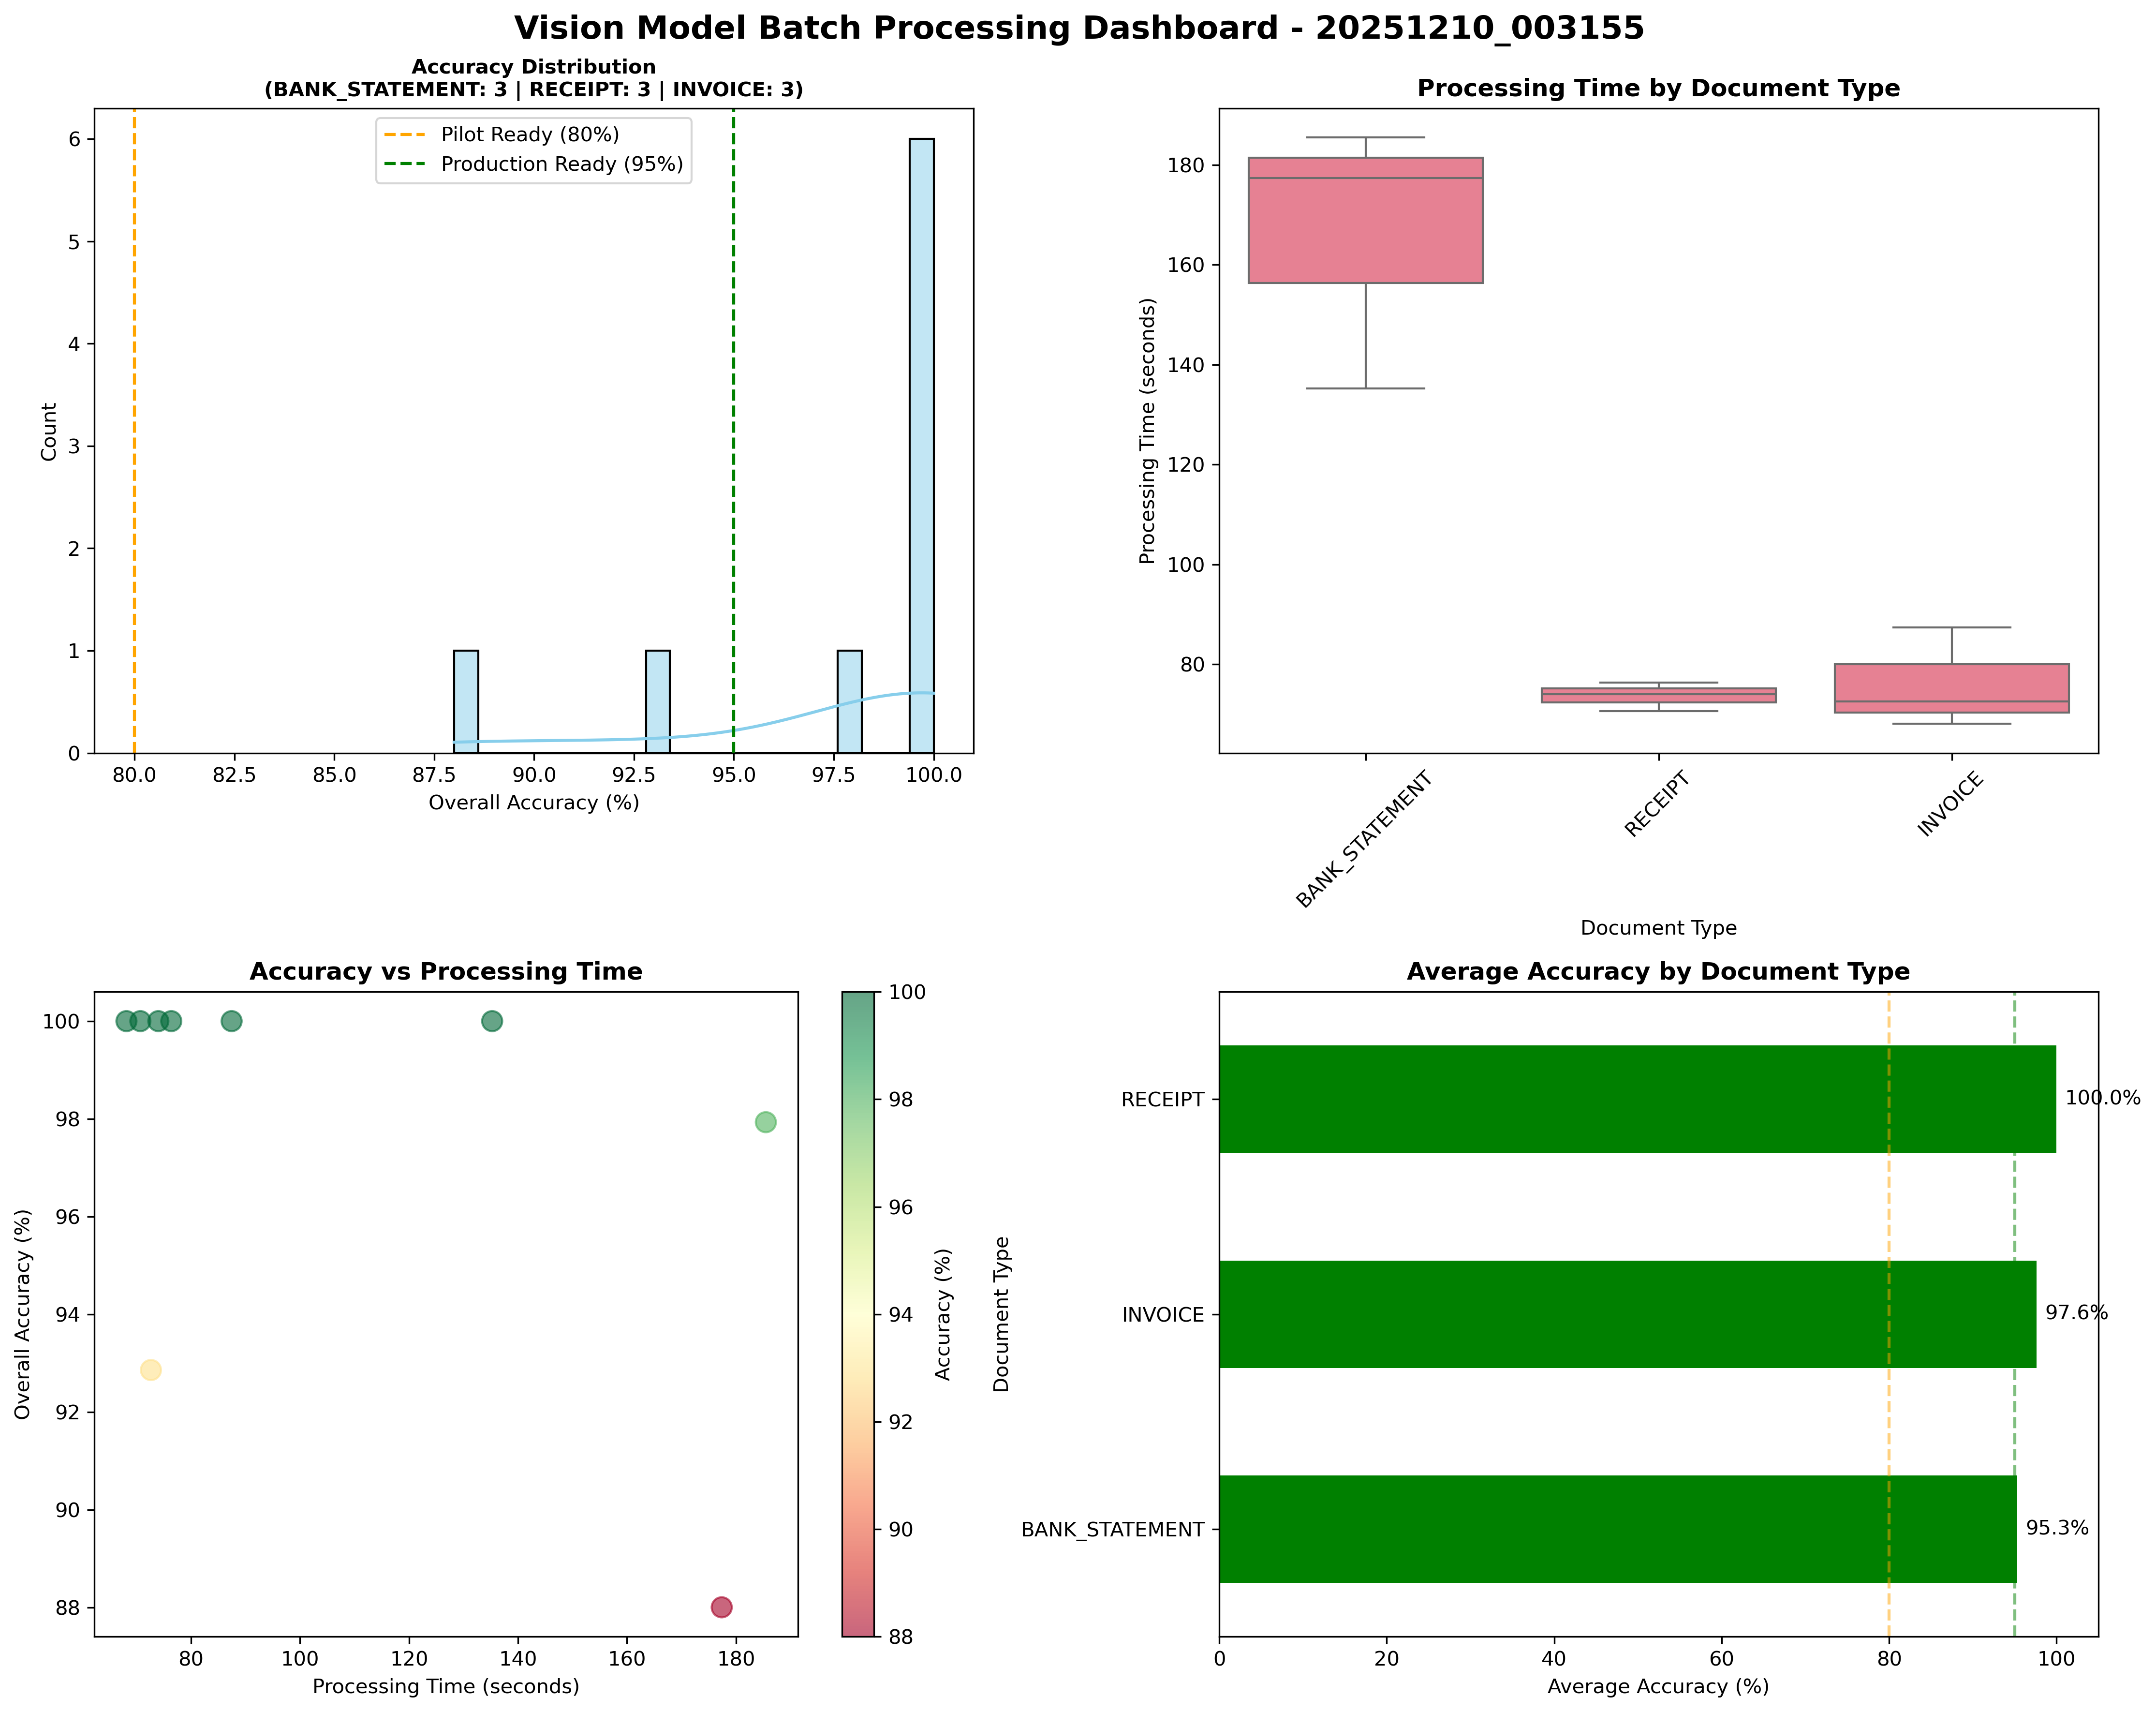

In [12]:
#Cell 11
# Display final summary
console.rule("[bold green]Batch Processing Complete[/bold green]")

total_images = len(batch_results)
successful = len([r for r in batch_results if 'error' not in r])
avg_accuracy = df_results['overall_accuracy'].mean() if len(df_results) > 0 else 0

rprint(f"[bold green]✅ Processed: {total_images} images[/bold green]")
rprint(f"[cyan]Success Rate: {(successful/total_images*100):.1f}%[/cyan]")
rprint(f"[cyan]Average Accuracy: {avg_accuracy:.2f}%[/cyan]")
rprint(f"[cyan]Output: {OUTPUT_BASE}[/cyan]")

# Display dashboard if available
dashboard_files = list(OUTPUT_DIRS['visualizations'].glob(f"dashboard_{BATCH_TIMESTAMP}.png"))
if dashboard_files:
    dashboard_path = dashboard_files[0]
    rprint("\n[bold blue]📊 Visual Dashboard:[/bold blue]")
    display(Image(str(dashboard_path)))
else:
    rprint(f"\n[yellow]⚠️ Dashboard not found in {OUTPUT_DIRS['visualizations']}[/yellow]")

In [13]:
#Cell 12
# Calculate zero accuracy extractions
zero_accuracy_count = 0
zero_accuracy_images = []
total_evaluated = 0

for result in batch_results:
    # Check if evaluation data exists (not inference-only mode)
    evaluation = result.get("evaluation", {})

    if evaluation and not evaluation.get("inference_only", False):
        total_evaluated += 1
        accuracy = evaluation.get("overall_accuracy", 0)

        if accuracy == 0.0:
            zero_accuracy_count += 1
            zero_accuracy_images.append(
                {
                    "image_name": result.get("image_name", "unknown"),
                    "document_type": result.get("document_type", "unknown"),
                    "fields_extracted": evaluation.get("fields_extracted", 0),
                    "total_fields": evaluation.get("total_fields", 0),
                }
            )

# Display results
if total_evaluated > 0:
    console.rule("[bold red]Zero Accuracy Analysis[/bold red]")

    rprint(f"[cyan]Total documents evaluated: {total_evaluated}[/cyan]")
    rprint(f"[red]Documents with 0% accuracy: {zero_accuracy_count}[/red]")

    if zero_accuracy_count > 0:
        percentage = (zero_accuracy_count / total_evaluated) * 100
        rprint(f"[red]Zero accuracy rate: {percentage:.1f}%[/red]")

        rprint("\n[bold red]Documents with 0% Accuracy:[/bold red]")
        for i, img_info in enumerate(zero_accuracy_images, 1):
            rprint(f"  {i}. {img_info['image_name']} ({img_info['document_type']})")
            rprint(
                f"     Fields extracted: {img_info['fields_extracted']}/{img_info['total_fields']}"
            )
    else:
        rprint(
            "[green]✅ No documents with 0% accuracy - all extractions had some success![/green]"
        )
else:
    rprint(
        "[yellow]⚠️ Running in inference-only mode - no accuracy metrics available[/yellow]"
    )


───────────────────────────────────────────── Zero Accuracy Analysis ──────────────────────────────────────────────

Total documents evaluated: 9

Documents with 0% accuracy: 0

✅ No documents with 0% accuracy - all extractions had some success!